## NLP-based prediction of genres based on their lyrics: II. Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [3]:
# Read the lemmatized dataset
songs = pd.read_csv('data/lemmatized_lyrics.csv')

In [4]:
# A general view of the lemmatized lyrics reveals that the outcome of lemmatization 
# has led to empty lists in some cases (24)
songs.describe()

,lyrics,genre
count,246328,246328
unique,244880,12
top,[],Rock
freq,24,107423


In [5]:
# Removing empty list lyrics and other variations of empty content
songs = songs[songs.lyrics!='[]']
songs = songs[songs.lyrics!='[\'instrumental\']']
songs = songs[songs.lyrics!='[\'lyric\', \'instrumental\']']
songs.describe()

,lyrics,genre
count,246279,246279
unique,244877,12
top,"['chestnut', 'roast', 'open', 'fire', 'jack', 'frost', 'nip', 'nose', 'yuletide', 'carol', 'sing...",Rock
freq,7,107395


In [6]:
# Interestingly, despite our previous removal of duplicate lyrics, lemmatizing reveals some redundancy
songs[songs.duplicated(keep=False)]

,lyrics,genre
1862,"['remember', 'burn', 'eye', 'world', 'bother', 'live', 'world', 'ecstasy', 'go', 'daydreamer', '...",Pop
1906,"['remember', 'burn', 'eye', 'world', 'bother', 'live', 'world', 'ecstasy', 'go', 'daydreamer', '...",Pop
10539,"['remember', 'hold', 'long', 'lonely', 'nights', 'sure', 'remember', 'say', 'goodbye', 'recall',...",Country
10580,"['remember', 'hold', 'long', 'lonely', 'nights', 'sure', 'remember', 'say', 'goodbye', 'recall',...",Country
12810,"['want', 'love', 'inspiration', 'want', 'love', 'start', 'tonight', 'instead', 'merely', 'hold',...",Blues
...,...,...
245952,"['well', 'first', 'affair', 'please', 'kind', 'handle', 'heart', 'care', 'please', 'kind', 'gran...",Jazz
246000,"['one', 'love', 'understand', 'oh', 'hard', 'luck', 'story', 'hand', 'pack', 'care', 'woe', 'go'...",Jazz
246044,"['want', 'make', 'go', 'want', 'make', 'come', 'want', 'push', 'away', 'want', 'feel', 'pain', '...",Rock
246054,"['want', 'make', 'go', 'want', 'make', 'come', 'want', 'push', 'away', 'want', 'feel', 'pain', '...",Rock


In [7]:
# Duplicates are dropped
songs = songs[~songs.lyrics.duplicated()]
songs.describe()

,lyrics,genre
count,244877,244877
unique,244877,12
top,"['love', 'get', 'power', 'love', 'get', 'power', 'thank', 'haeya', 'ayiyiya', 'love', 'get', 'po...",Rock
freq,1,106703


In [8]:
# In order to perform some EDA, our lemmatized lyrics will be needed to be reconverted to single strings in some
# occasions. A new temp column is added. Inspiration drawn from: https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

# Our list is interpreted as a string by pd.read_csv, so we first convert it back to a list
songs.lyrics = songs.lyrics.apply(ast.literal_eval)

# Now we create the new column
songs['lyrics_str'] = [' '.join(map(str,lemmatized)) for lemmatized in songs.lyrics]
songs.head()

,lyrics,genre,lyrics_str
0,"[hold, time, feel, break, feel, untrue, convince, speak, voice, tear, try, hold, hurt, try, forg...",Pop,hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play b...
1,"[believe, drop, rain, fall, grow, believe, dark, night, candle, glow, believe, go, astray, come,...",Pop,believe drop rain fall grow believe dark night candle glow believe go astray come believe believ...
2,"[sweetheart, send, letter, goodbye, secret, feel, well, wake, dream, think, real, false, emotion...",Pop,sweetheart send letter goodbye secret feel well wake dream think real false emotion feel heartac...
3,"[kiss, lip, want, stroll, charm, mambo, chacha, meringue, heaven, arm, japan, brag, geisha, care...",Pop,kiss lip want stroll charm mambo chacha meringue heaven arm japan brag geisha care long uncle ey...
4,"[till, darling, till, matter, know, till, dream, live, apart, know, heart, till, world, free, oc...",Pop,till darling till matter know till dream live apart know heart till world free ocean cross mount...


In [9]:
# Attaching TextBlob sentiment analysis
songs['TB_sentiment'] = songs['lyrics_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Attaching Vader sentiment analysis
vader = SentimentIntensityAnalyzer()
songs['V_sentiment'] = songs['lyrics_str'].apply(lambda x: vader.polarity_scores(x)['compound'])

songs.head(10)

,lyrics,genre,lyrics_str,TB_sentiment,V_sentiment
0,"[hold, time, feel, break, feel, untrue, convince, speak, voice, tear, try, hold, hurt, try, forg...",Pop,hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play b...,-0.153125,0.9253
1,"[believe, drop, rain, fall, grow, believe, dark, night, candle, glow, believe, go, astray, come,...",Pop,believe drop rain fall grow believe dark night candle glow believe go astray come believe believ...,0.125000,-0.5423
2,"[sweetheart, send, letter, goodbye, secret, feel, well, wake, dream, think, real, false, emotion...",Pop,sweetheart send letter goodbye secret feel well wake dream think real false emotion feel heartac...,-0.262500,0.8126
3,"[kiss, lip, want, stroll, charm, mambo, chacha, meringue, heaven, arm, japan, brag, geisha, care...",Pop,kiss lip want stroll charm mambo chacha meringue heaven arm japan brag geisha care long uncle ey...,0.150000,0.9887
4,"[till, darling, till, matter, know, till, dream, live, apart, know, heart, till, world, free, oc...",Pop,till darling till matter know till dream live apart know heart till world free ocean cross mount...,0.134091,0.9618
5,"[convoy, light, dead, ahead, merchantman, trump, diesel, hammer, oily, kill, grind, knuckle, whi...",Pop,convoy light dead ahead merchantman trump diesel hammer oily kill grind knuckle white eye alight...,-0.071377,-0.9771
6,"[piece, mindin, world, knowin, life, come, bring, give, world, know, give, reason, feelin, give,...",Pop,piece mindin world knowin life come bring give world know give reason feelin give mean life go e...,0.035714,0.8555
7,"[care, moment, hold, fast, press, lip, dream, heaven, speak, share, glow, grow, pas, meet, break...",Pop,care moment hold fast press lip dream heaven speak share glow grow pas meet break speak share gl...,0.200000,0.8979
8,"[lonely, night, surround, power, read, mind, hour, night, kiss, lip, hold, tight, unending, real...",Pop,lonely night surround power read mind hour night kiss lip hold tight unending real begin lonely ...,-0.023810,0.4019
9,"[tear, heart, seat, stay, awhile, tear, heart, game, steal, glimpse, eye, stare, awhile, steal, ...",Pop,tear heart seat stay awhile tear heart game steal glimpse eye stare awhile steal glimpse eye gam...,-0.192399,0.1531


As demonstrated above, different sentiment analyzers might produce vastly different evaluations in a scale from -1 to 1. In this case, we will likely favor the TextBlob analyzer as it relies less on full sentence structure than Vader does.

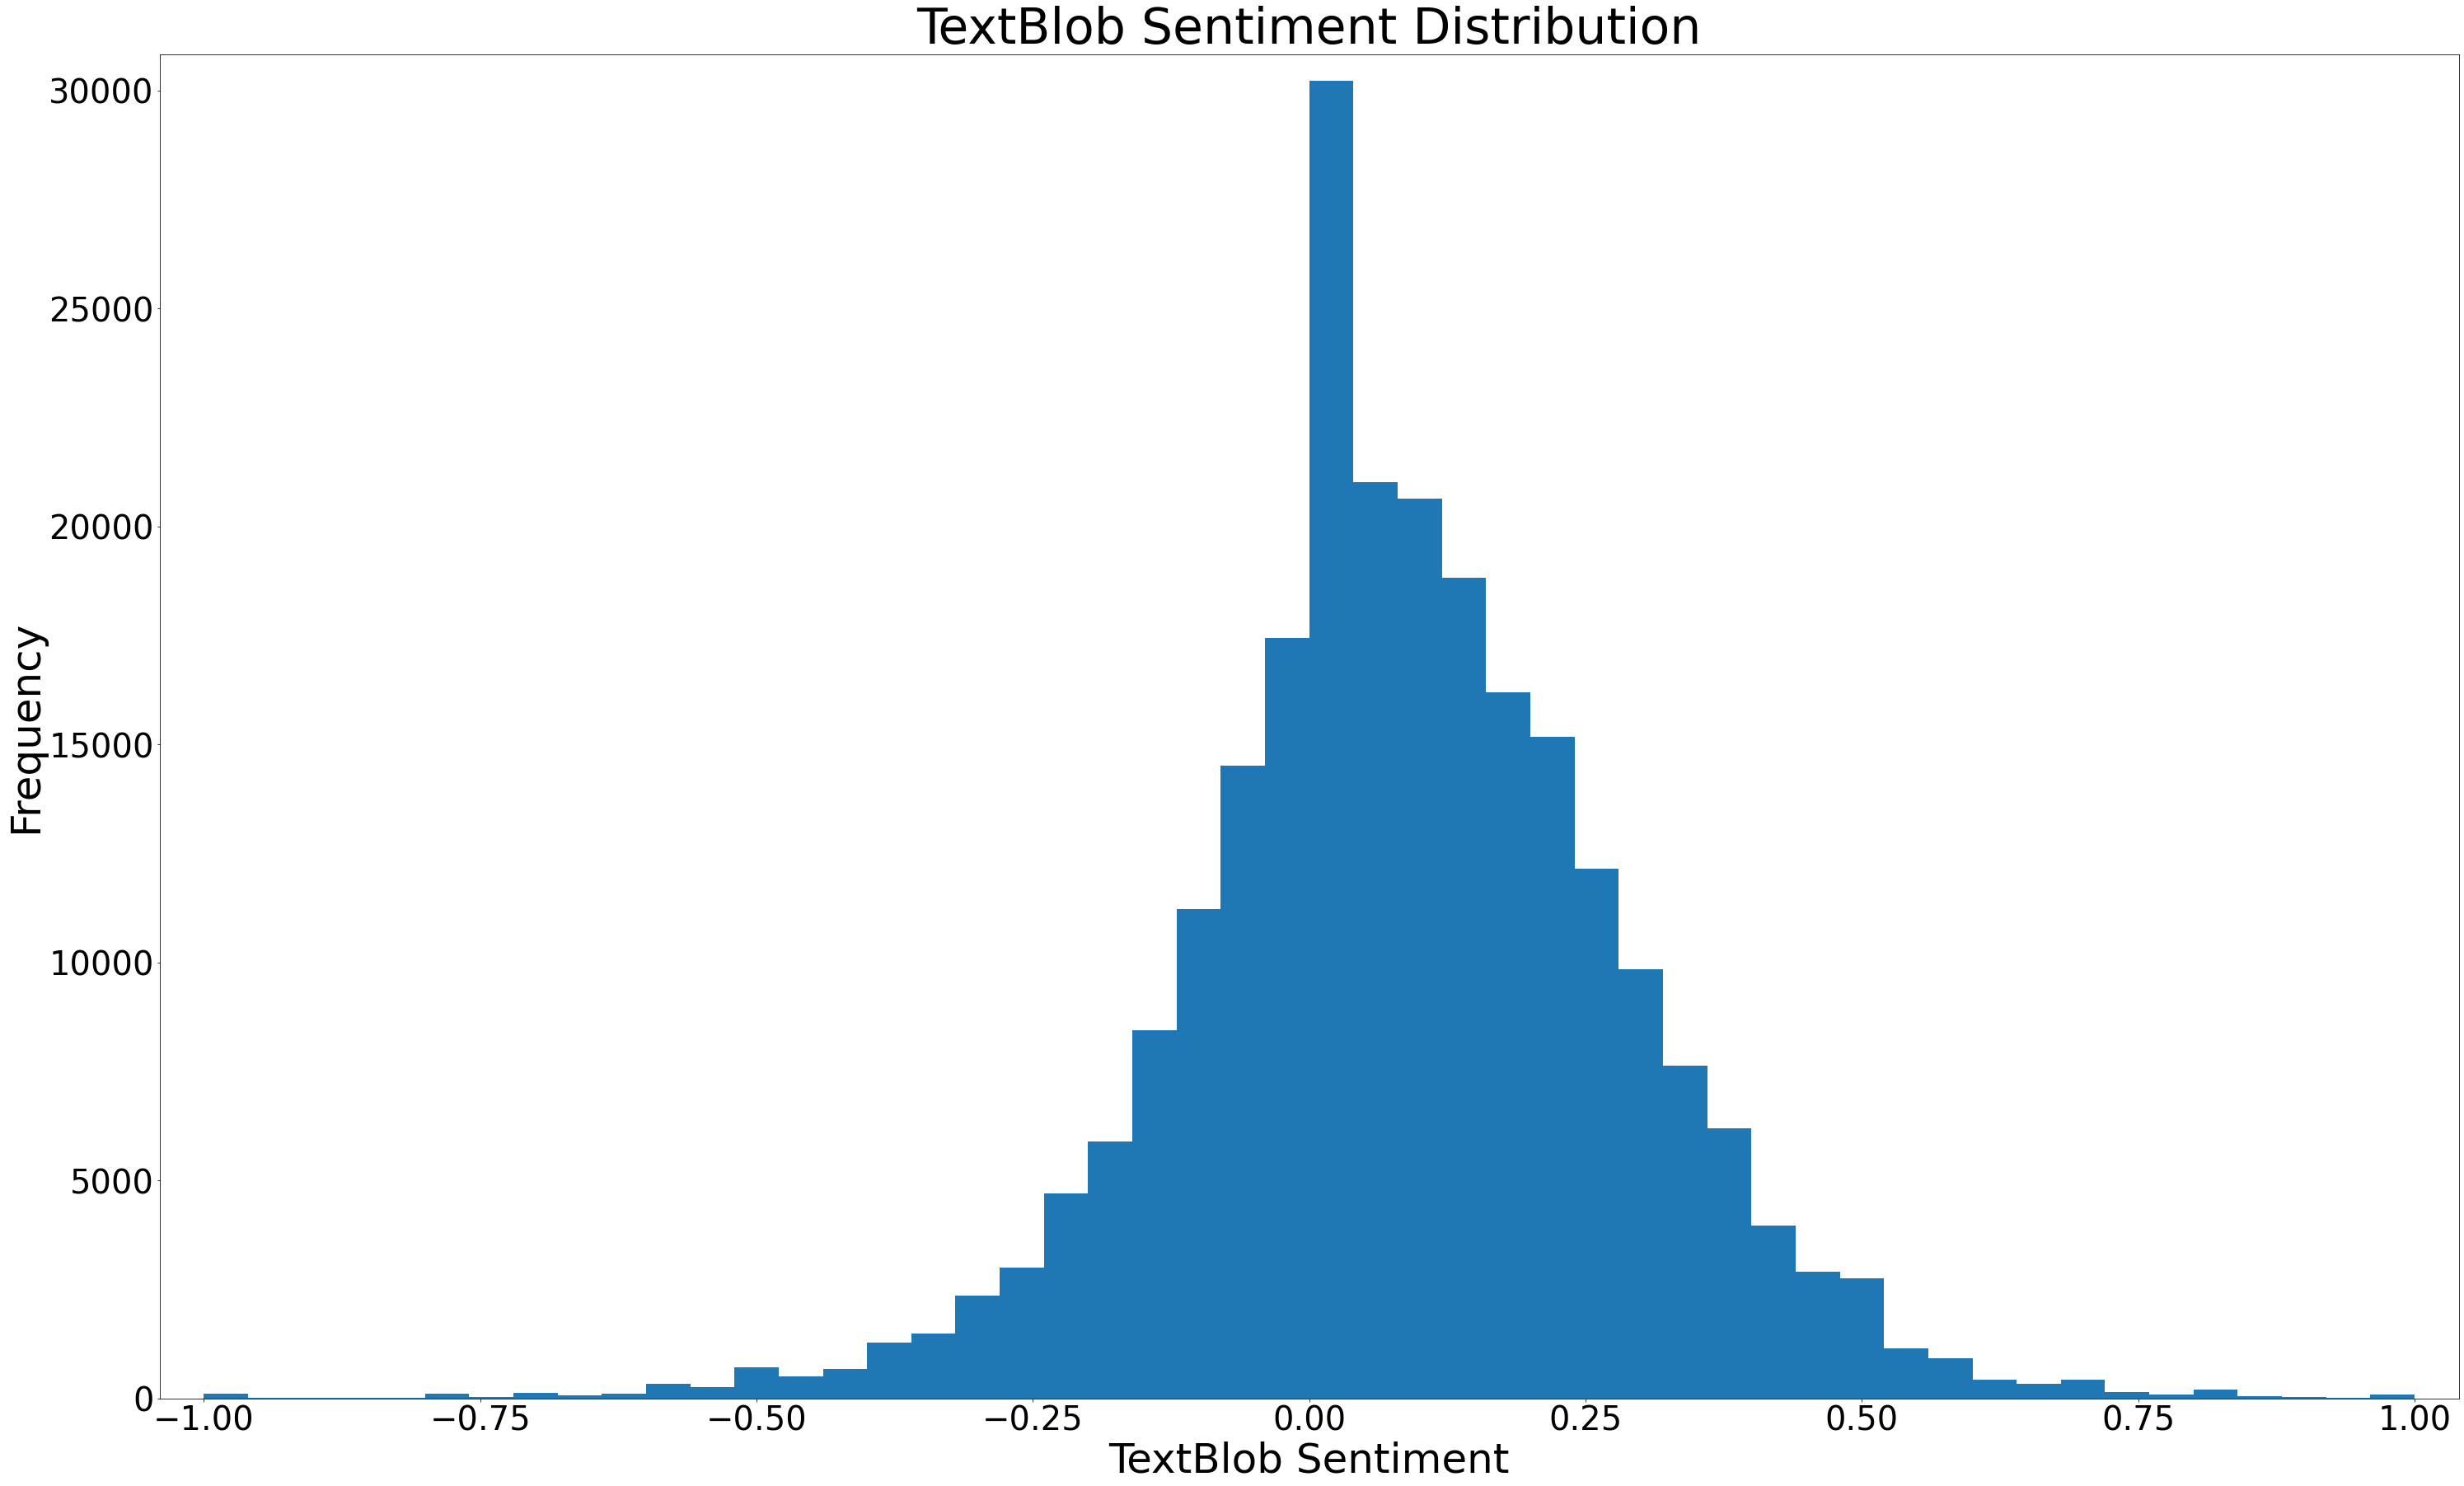

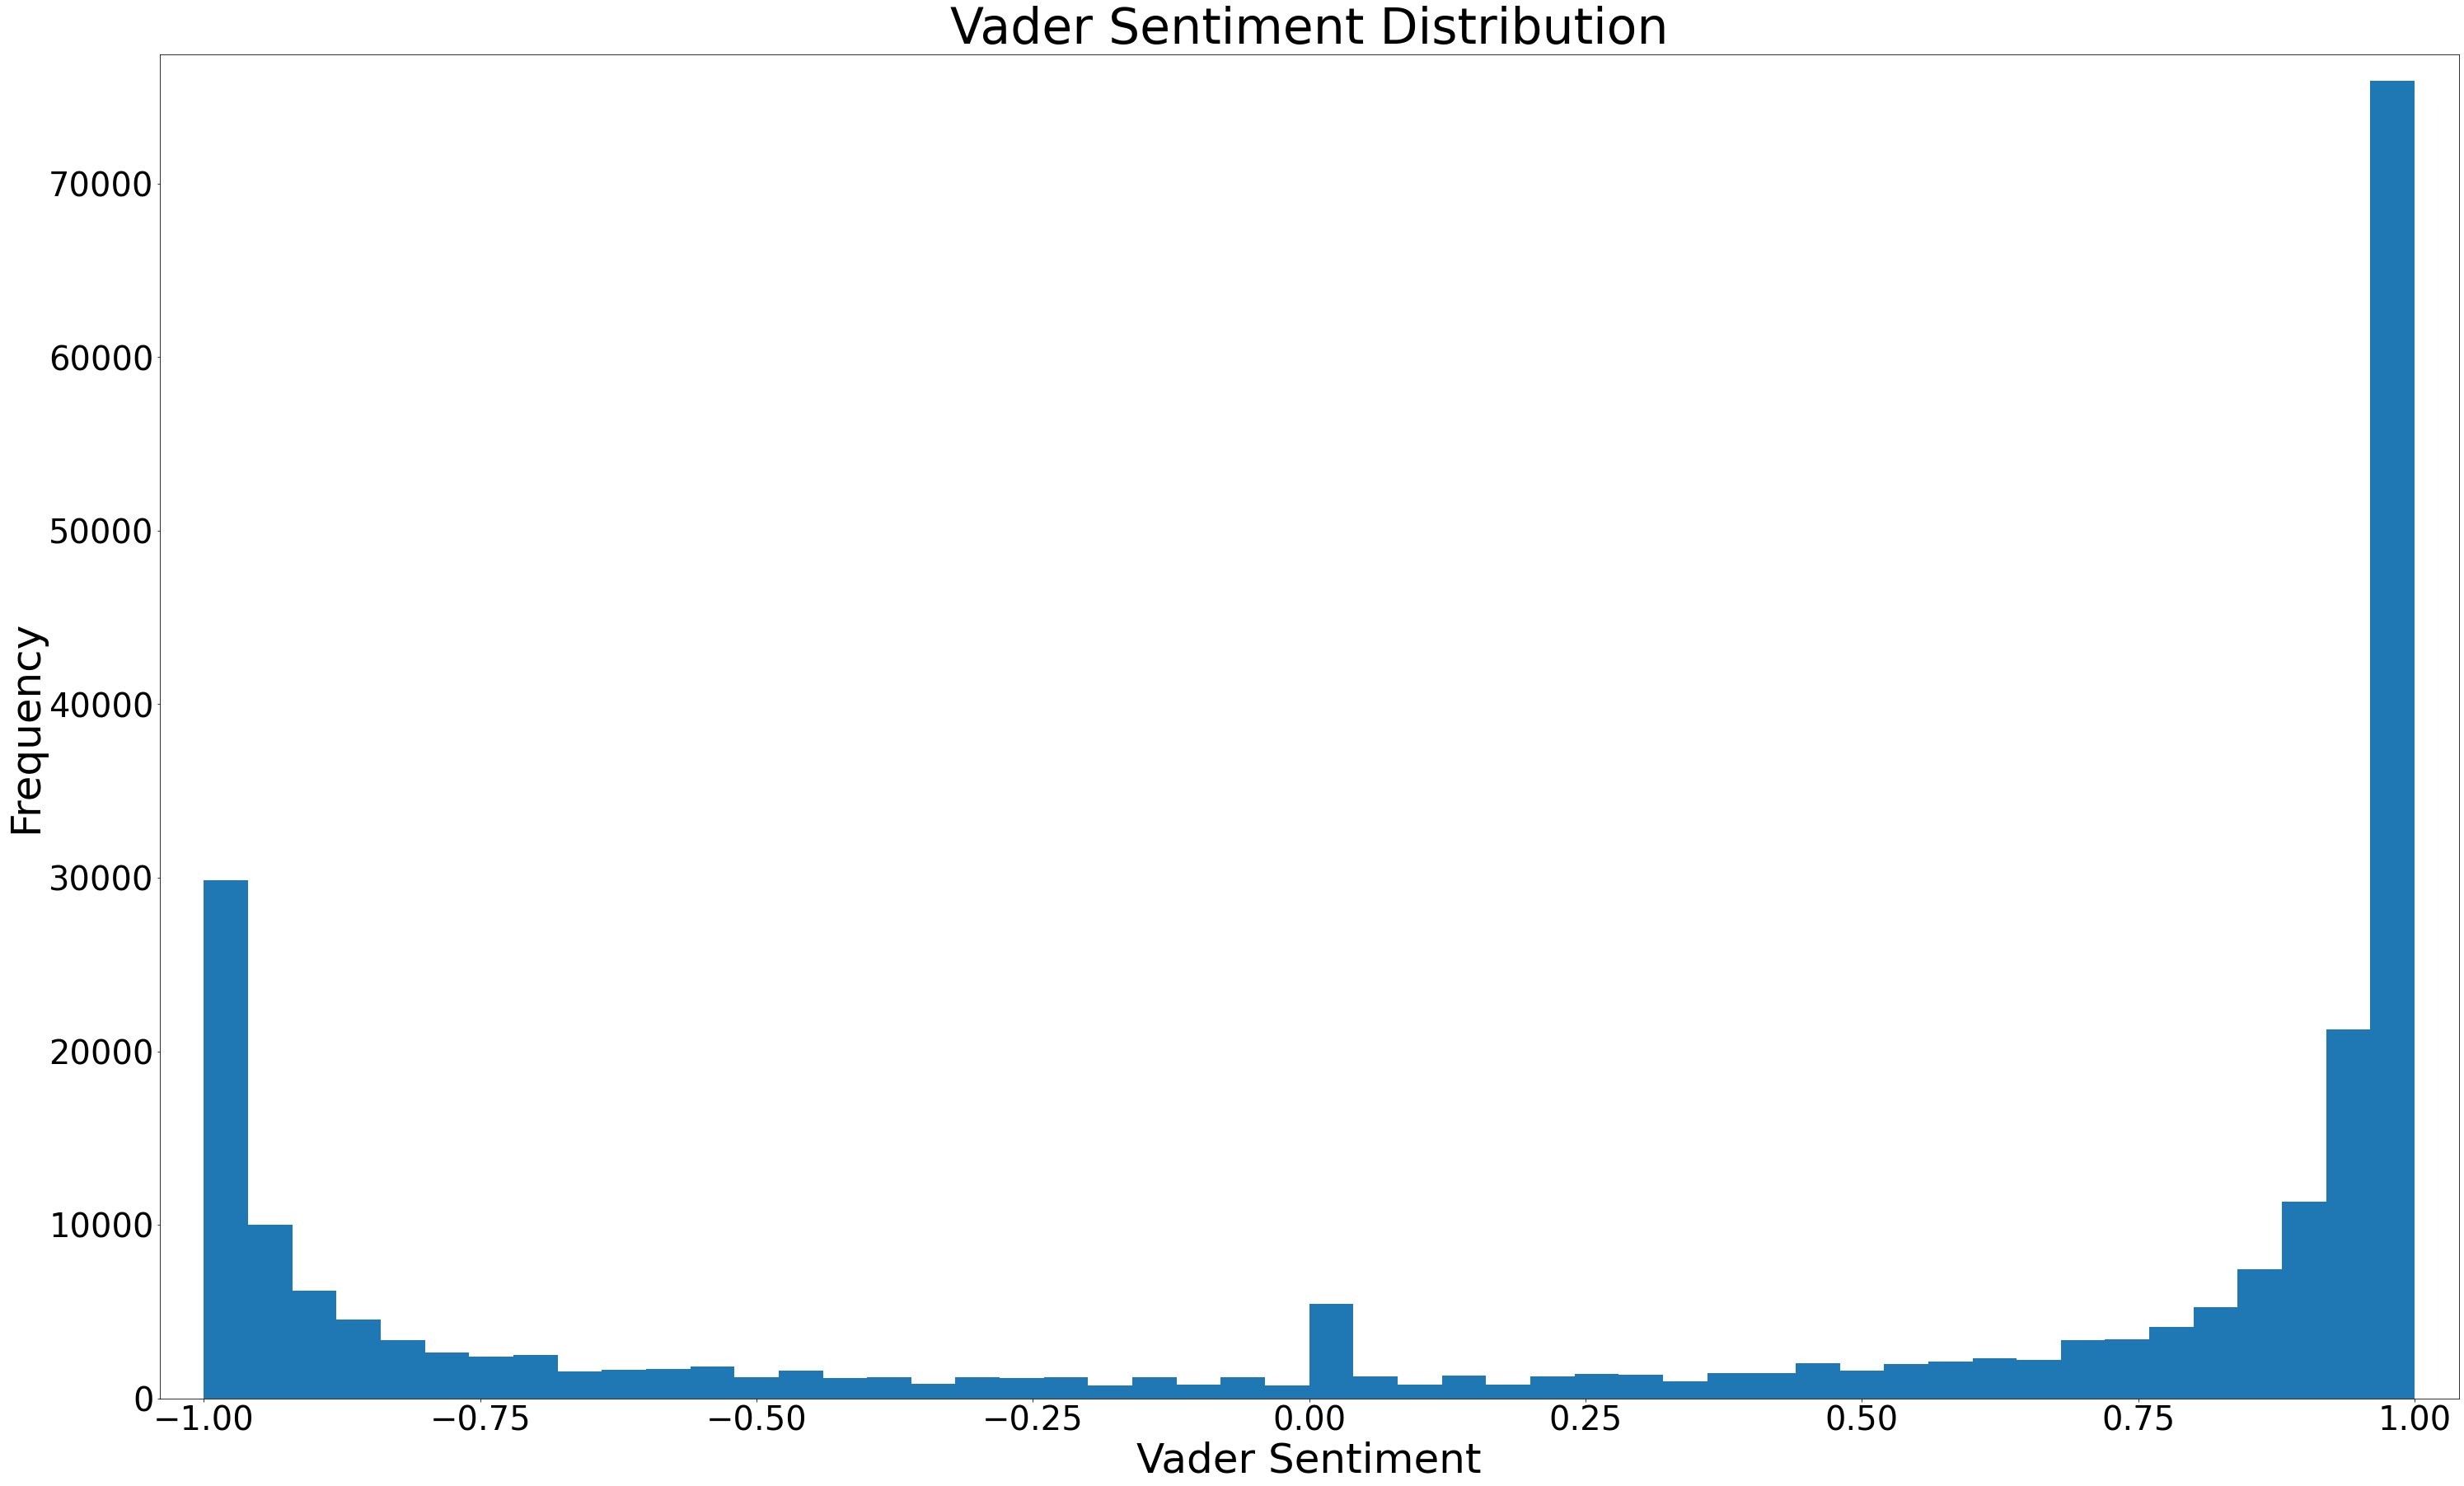

In [115]:
# What is the overall sentiment distribution in this corpus? How do the two sentiment analyzers analyze the corpus?

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('TextBlob Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(songs.TB_sentiment, bins=50)
plt.title('TextBlob Sentiment Distribution', fontsize=60)
plt.show()

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Vader Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(songs.V_sentiment, bins=50)
plt.title('Vader Sentiment Distribution', fontsize=60)
plt.show()

The figures above further reinforce differences in sentiment analysis according to which packages are used. Vader is quicker to polarize, and TextBlob is more moderate, yielding an almost normal distribution.

In [171]:
# What is the average sentiment per genre according to the two sentiment analyzers?
bar = songs.groupby('genre')[['TB_sentiment','V_sentiment']].mean()
bar.reset_index(inplace=True)
bar = bar.melt('genre', var_name='sentiment', value_name='values')

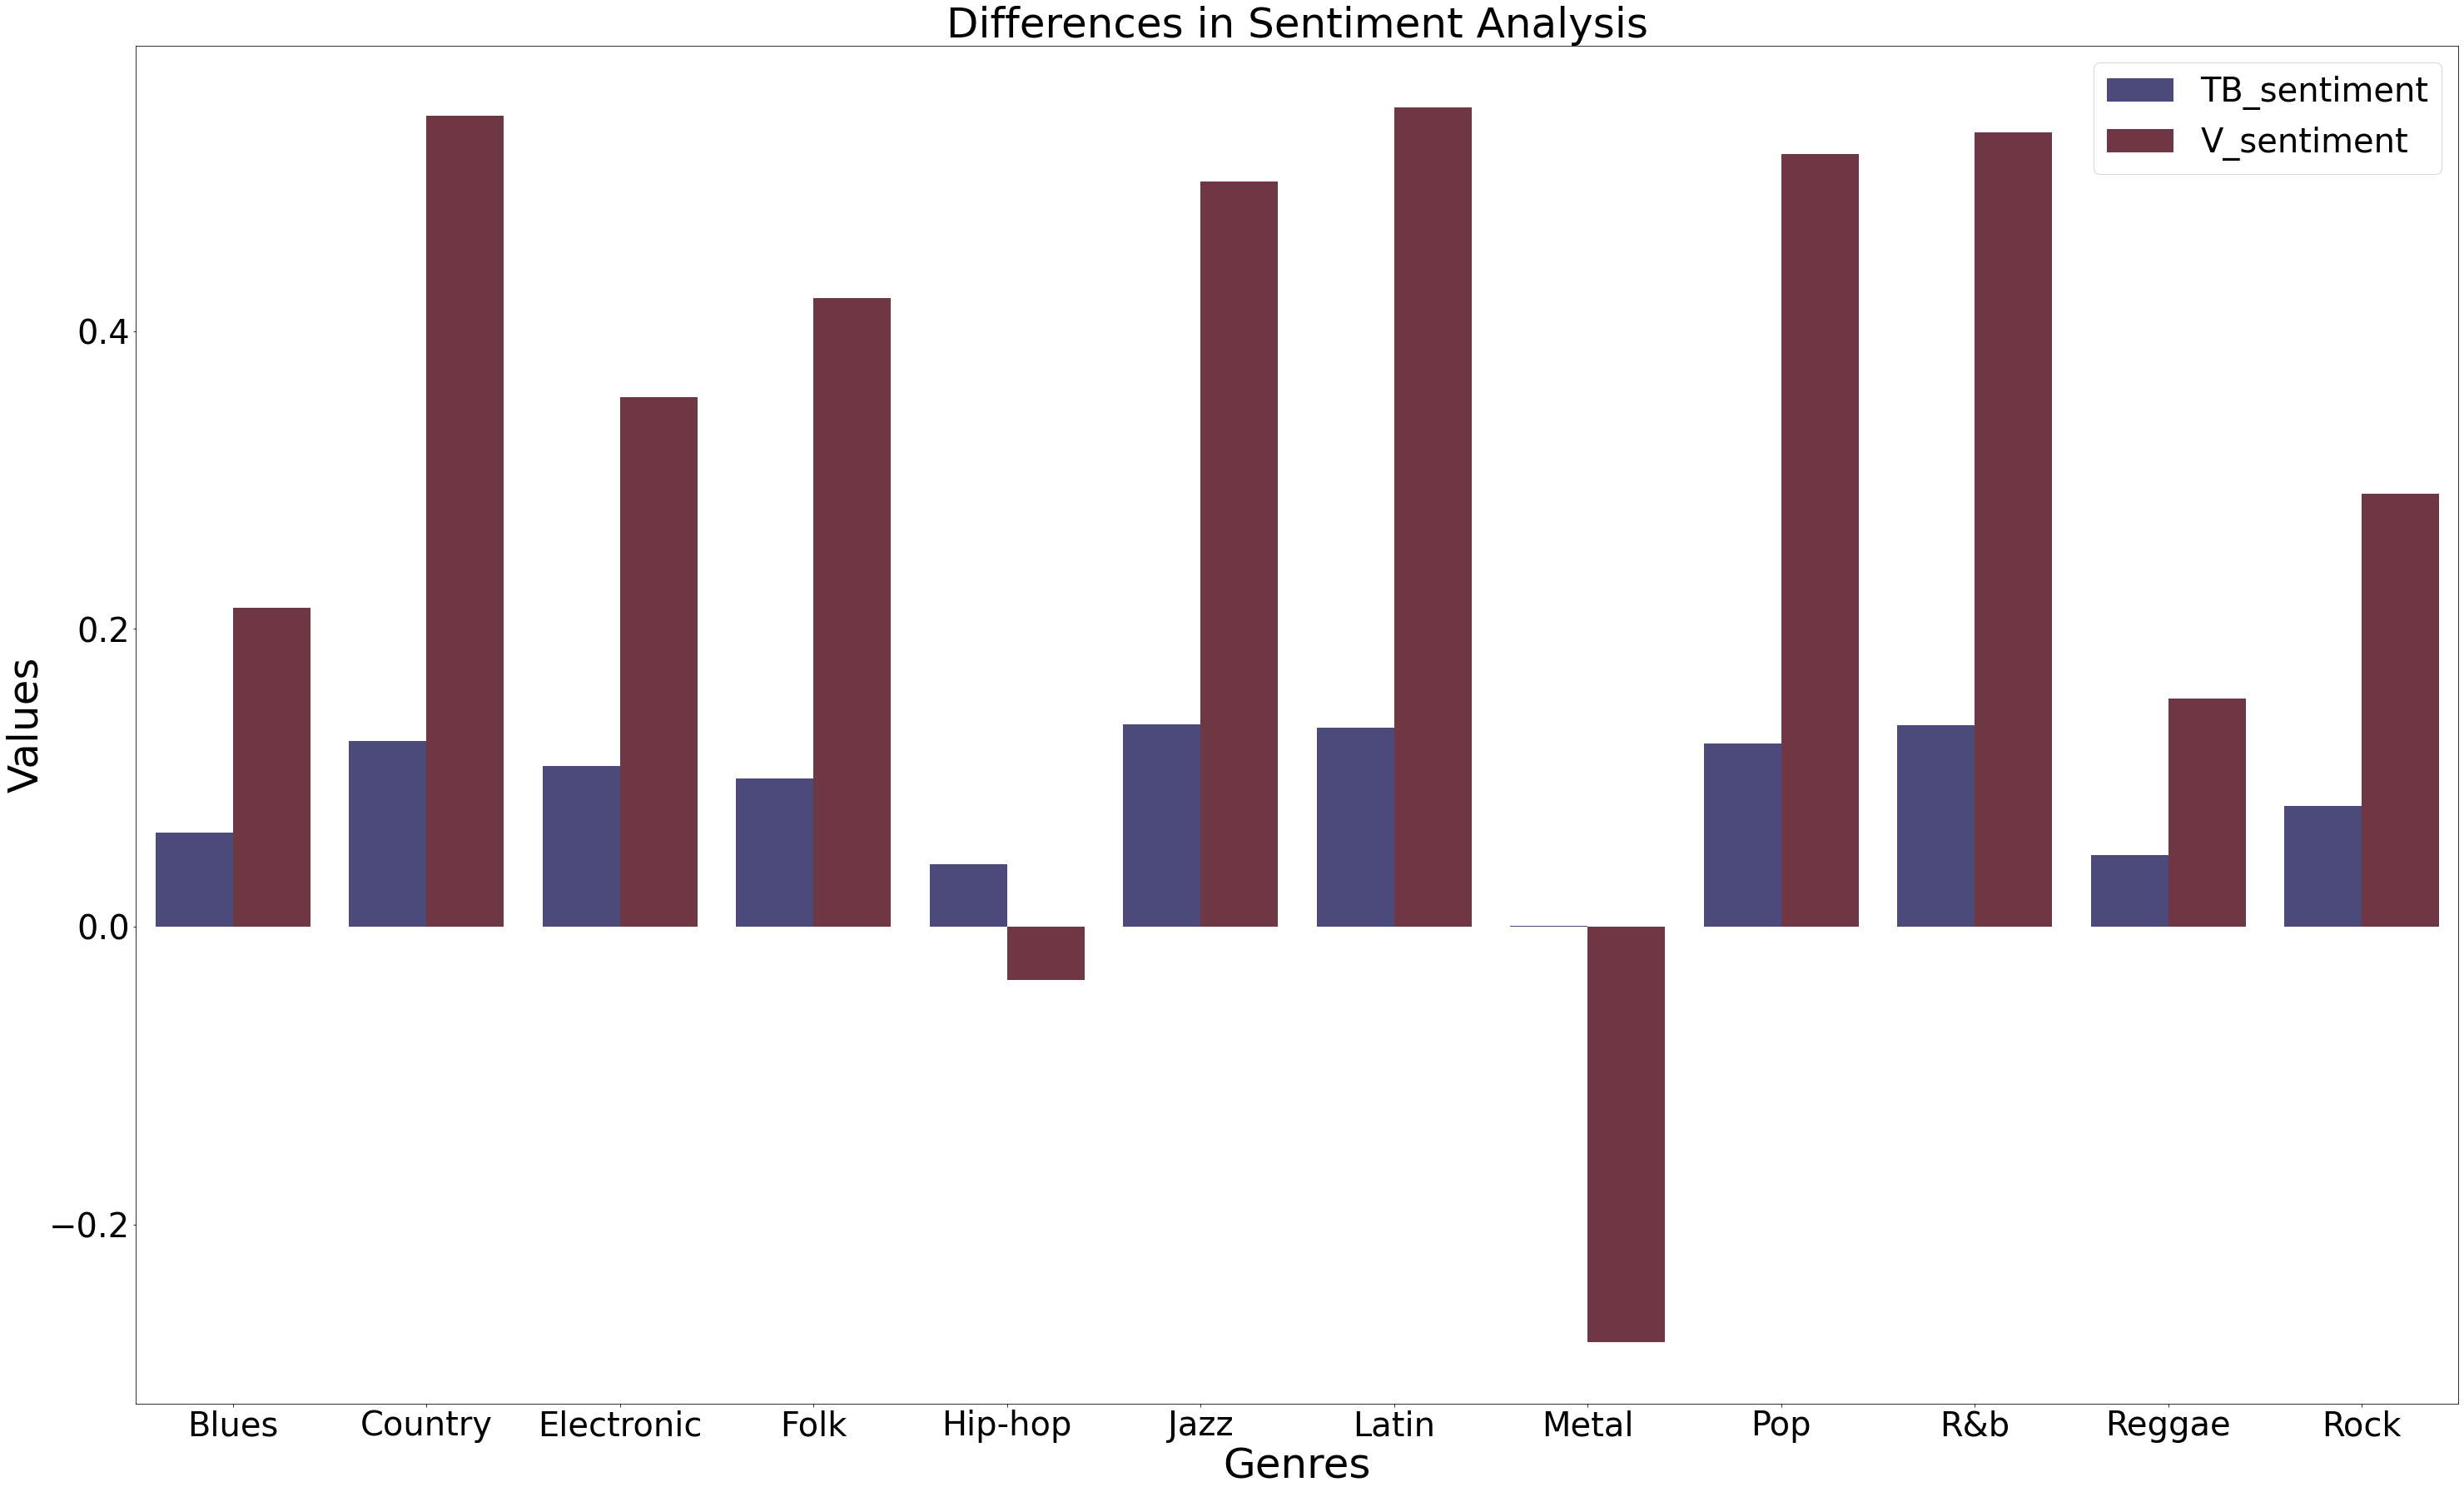

In [185]:
plt.figure(figsize=(50,30))
ax = sns.barplot(x='genre', y='values', hue='sentiment', data=bar, palette='icefire')
plt.title("Differences in Sentiment Analysis", fontsize=50)
plt.ylabel('Values', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.legend(fontsize=40)
plt.show()

Again, we confirm the differences in sentiment encoding produced by TextBlob and Vader.

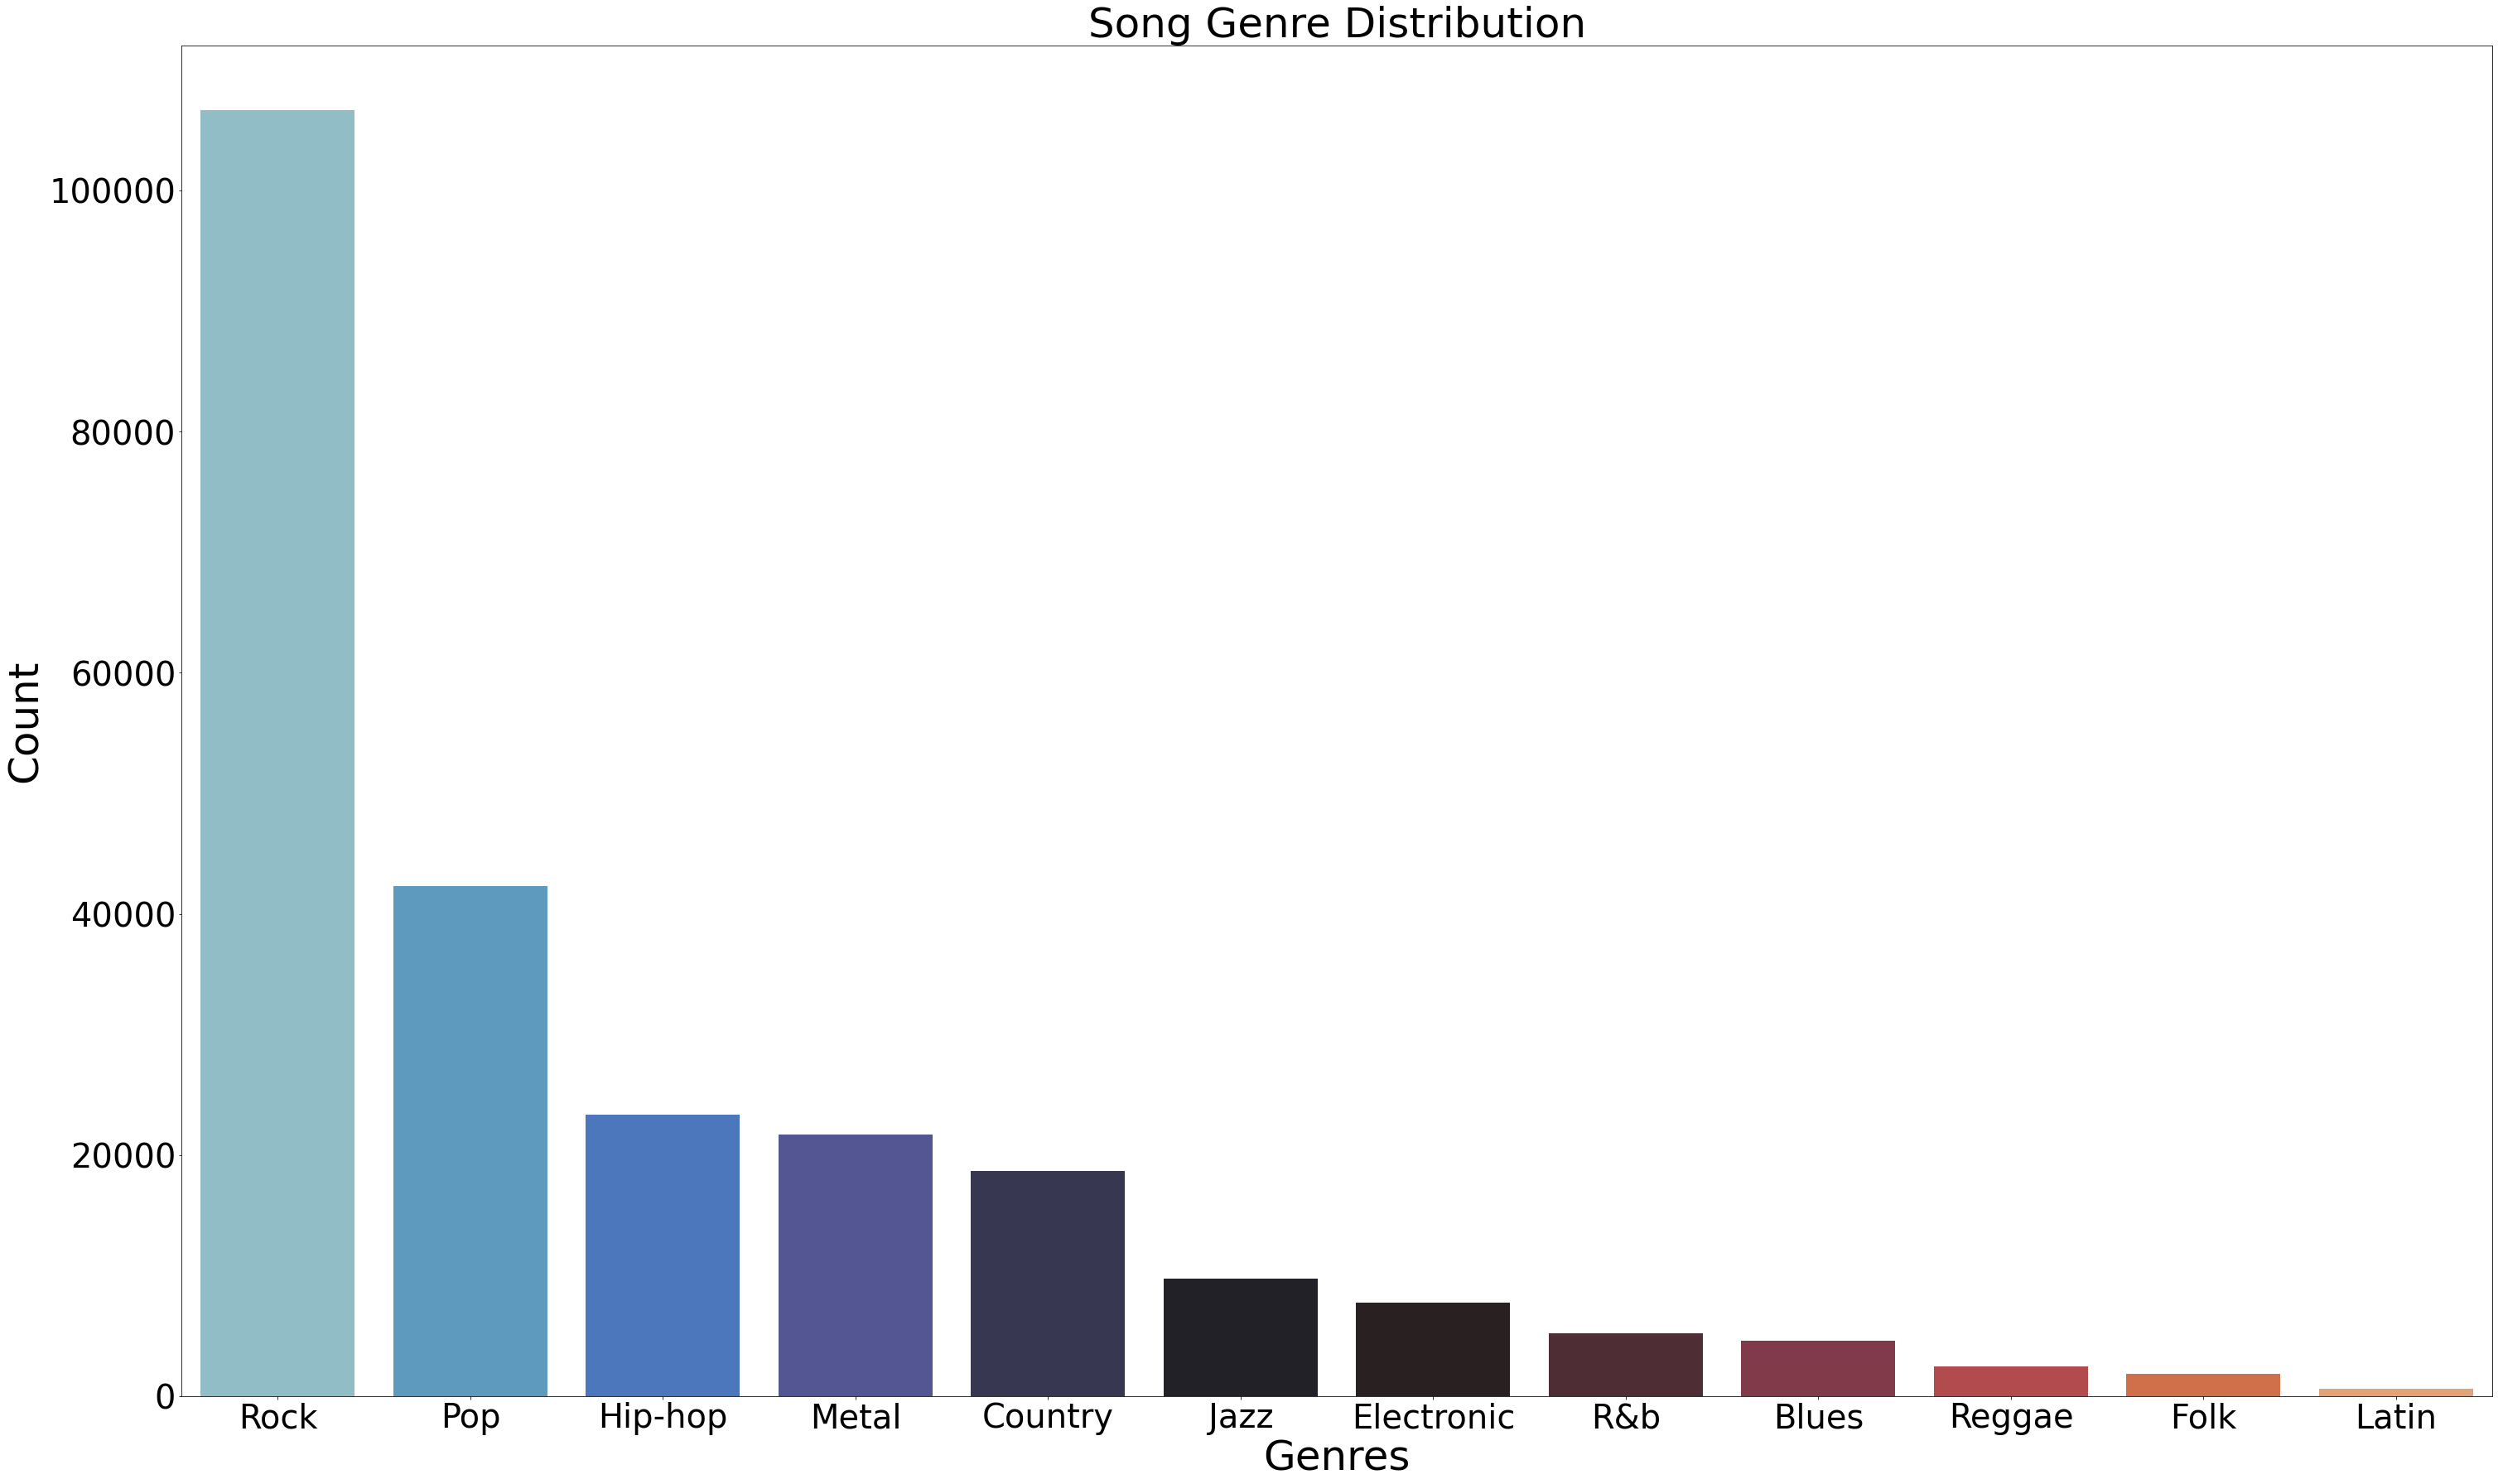

In [163]:
# What is our genre distribution?
x = songs.genre.value_counts()
y = x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x=x.index, y=x.values, palette='icefire')
plt.title("Song Genre Distribution", fontsize=50)
plt.ylabel('Count', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.show()

As the figure above demonstrates, we have a classic case of class imbalance in our hands. We will have to decide, prior to training, how we will handle this situation.

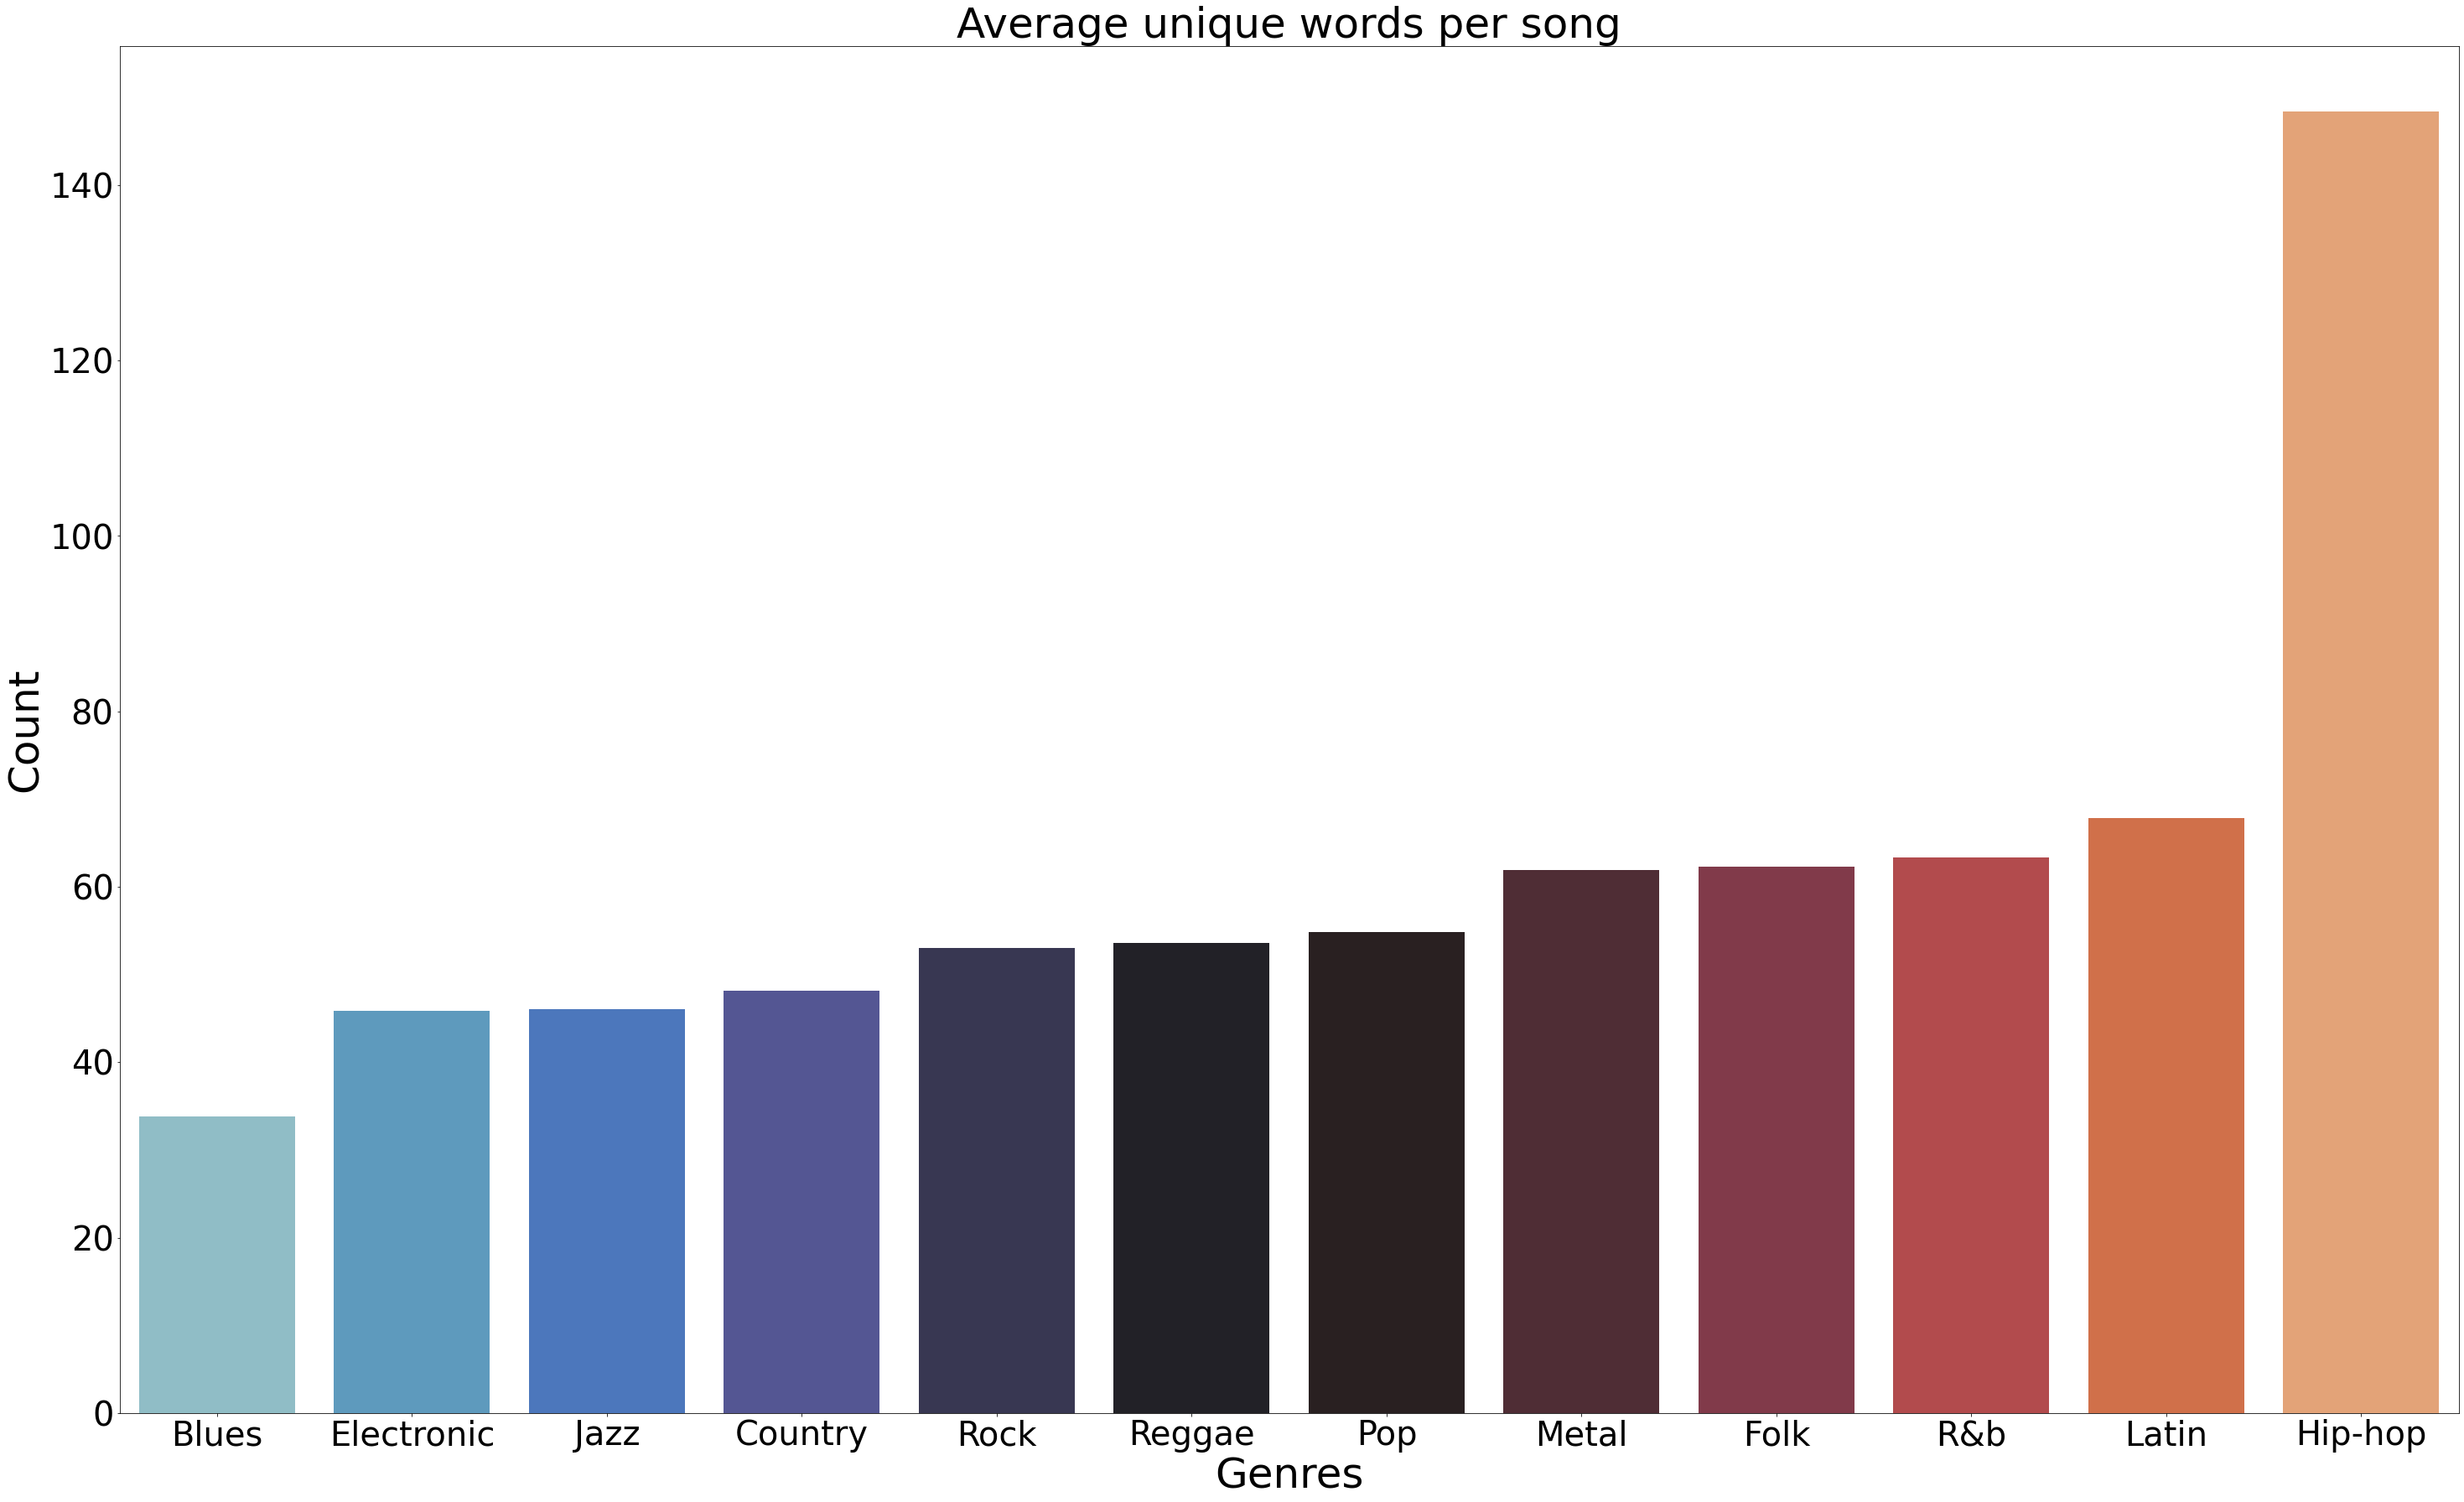

In [162]:
# Which genres use a more diverse vocabulary?

# First, we count the number of unique words per song
songs['unique_words'] = songs.lyrics_str.apply(lambda x: len(set(x.split())))

# We group by genre and calculate the mean
genre_unique_words = songs.groupby("genre").unique_words.mean()

# And we plot a bar graph
genre_unique_words.sort_values(inplace=True)
plt.figure(figsize=(50,30))
sns.barplot(x=genre_unique_words.index, y=genre_unique_words.values, palette='icefire')
plt.title("Average unique words per song", fontsize=50)
plt.ylabel('Count', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Genres', fontsize=50)
plt.xticks(fontsize=40)
plt.show()

Unsuprisingly, hip-hop is an outlier as the more verbose lyrical genre.

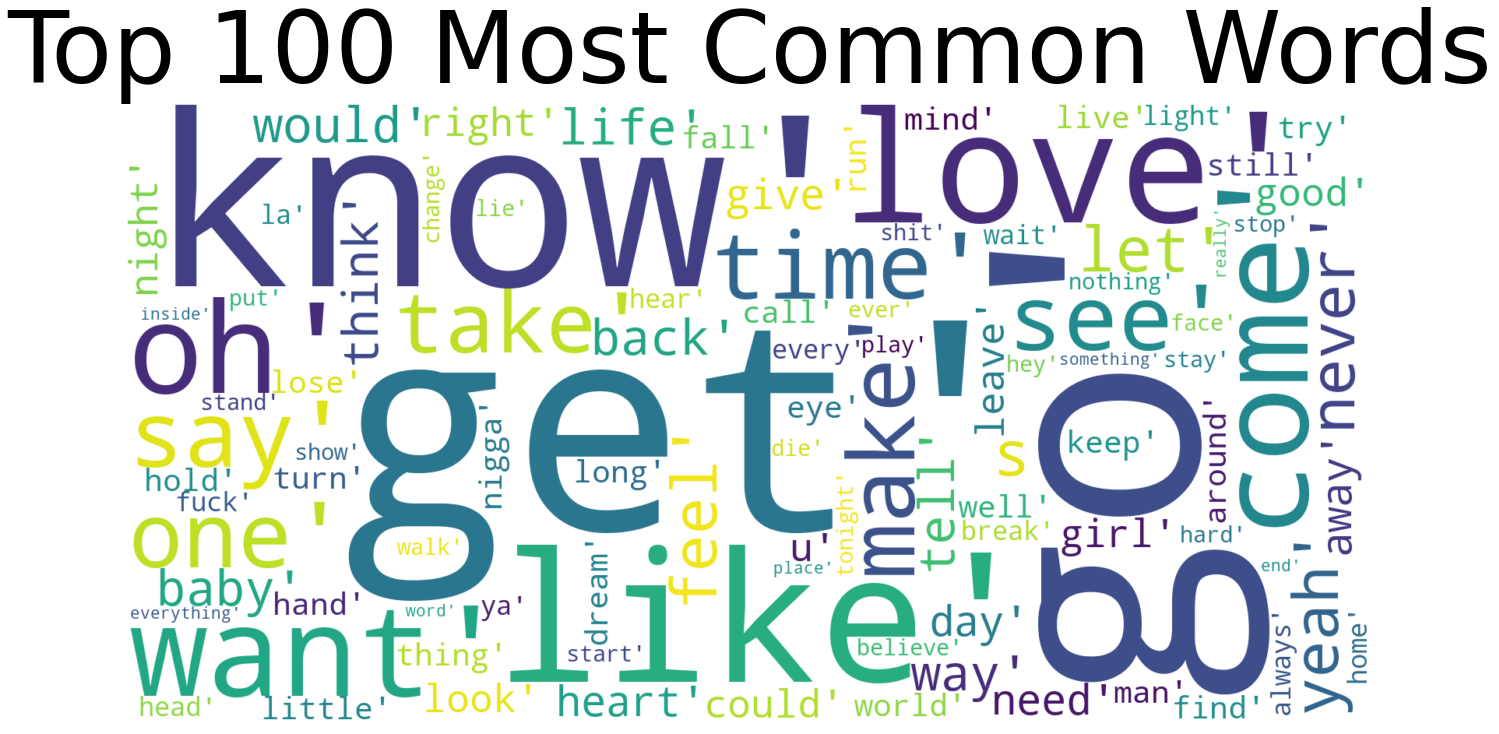

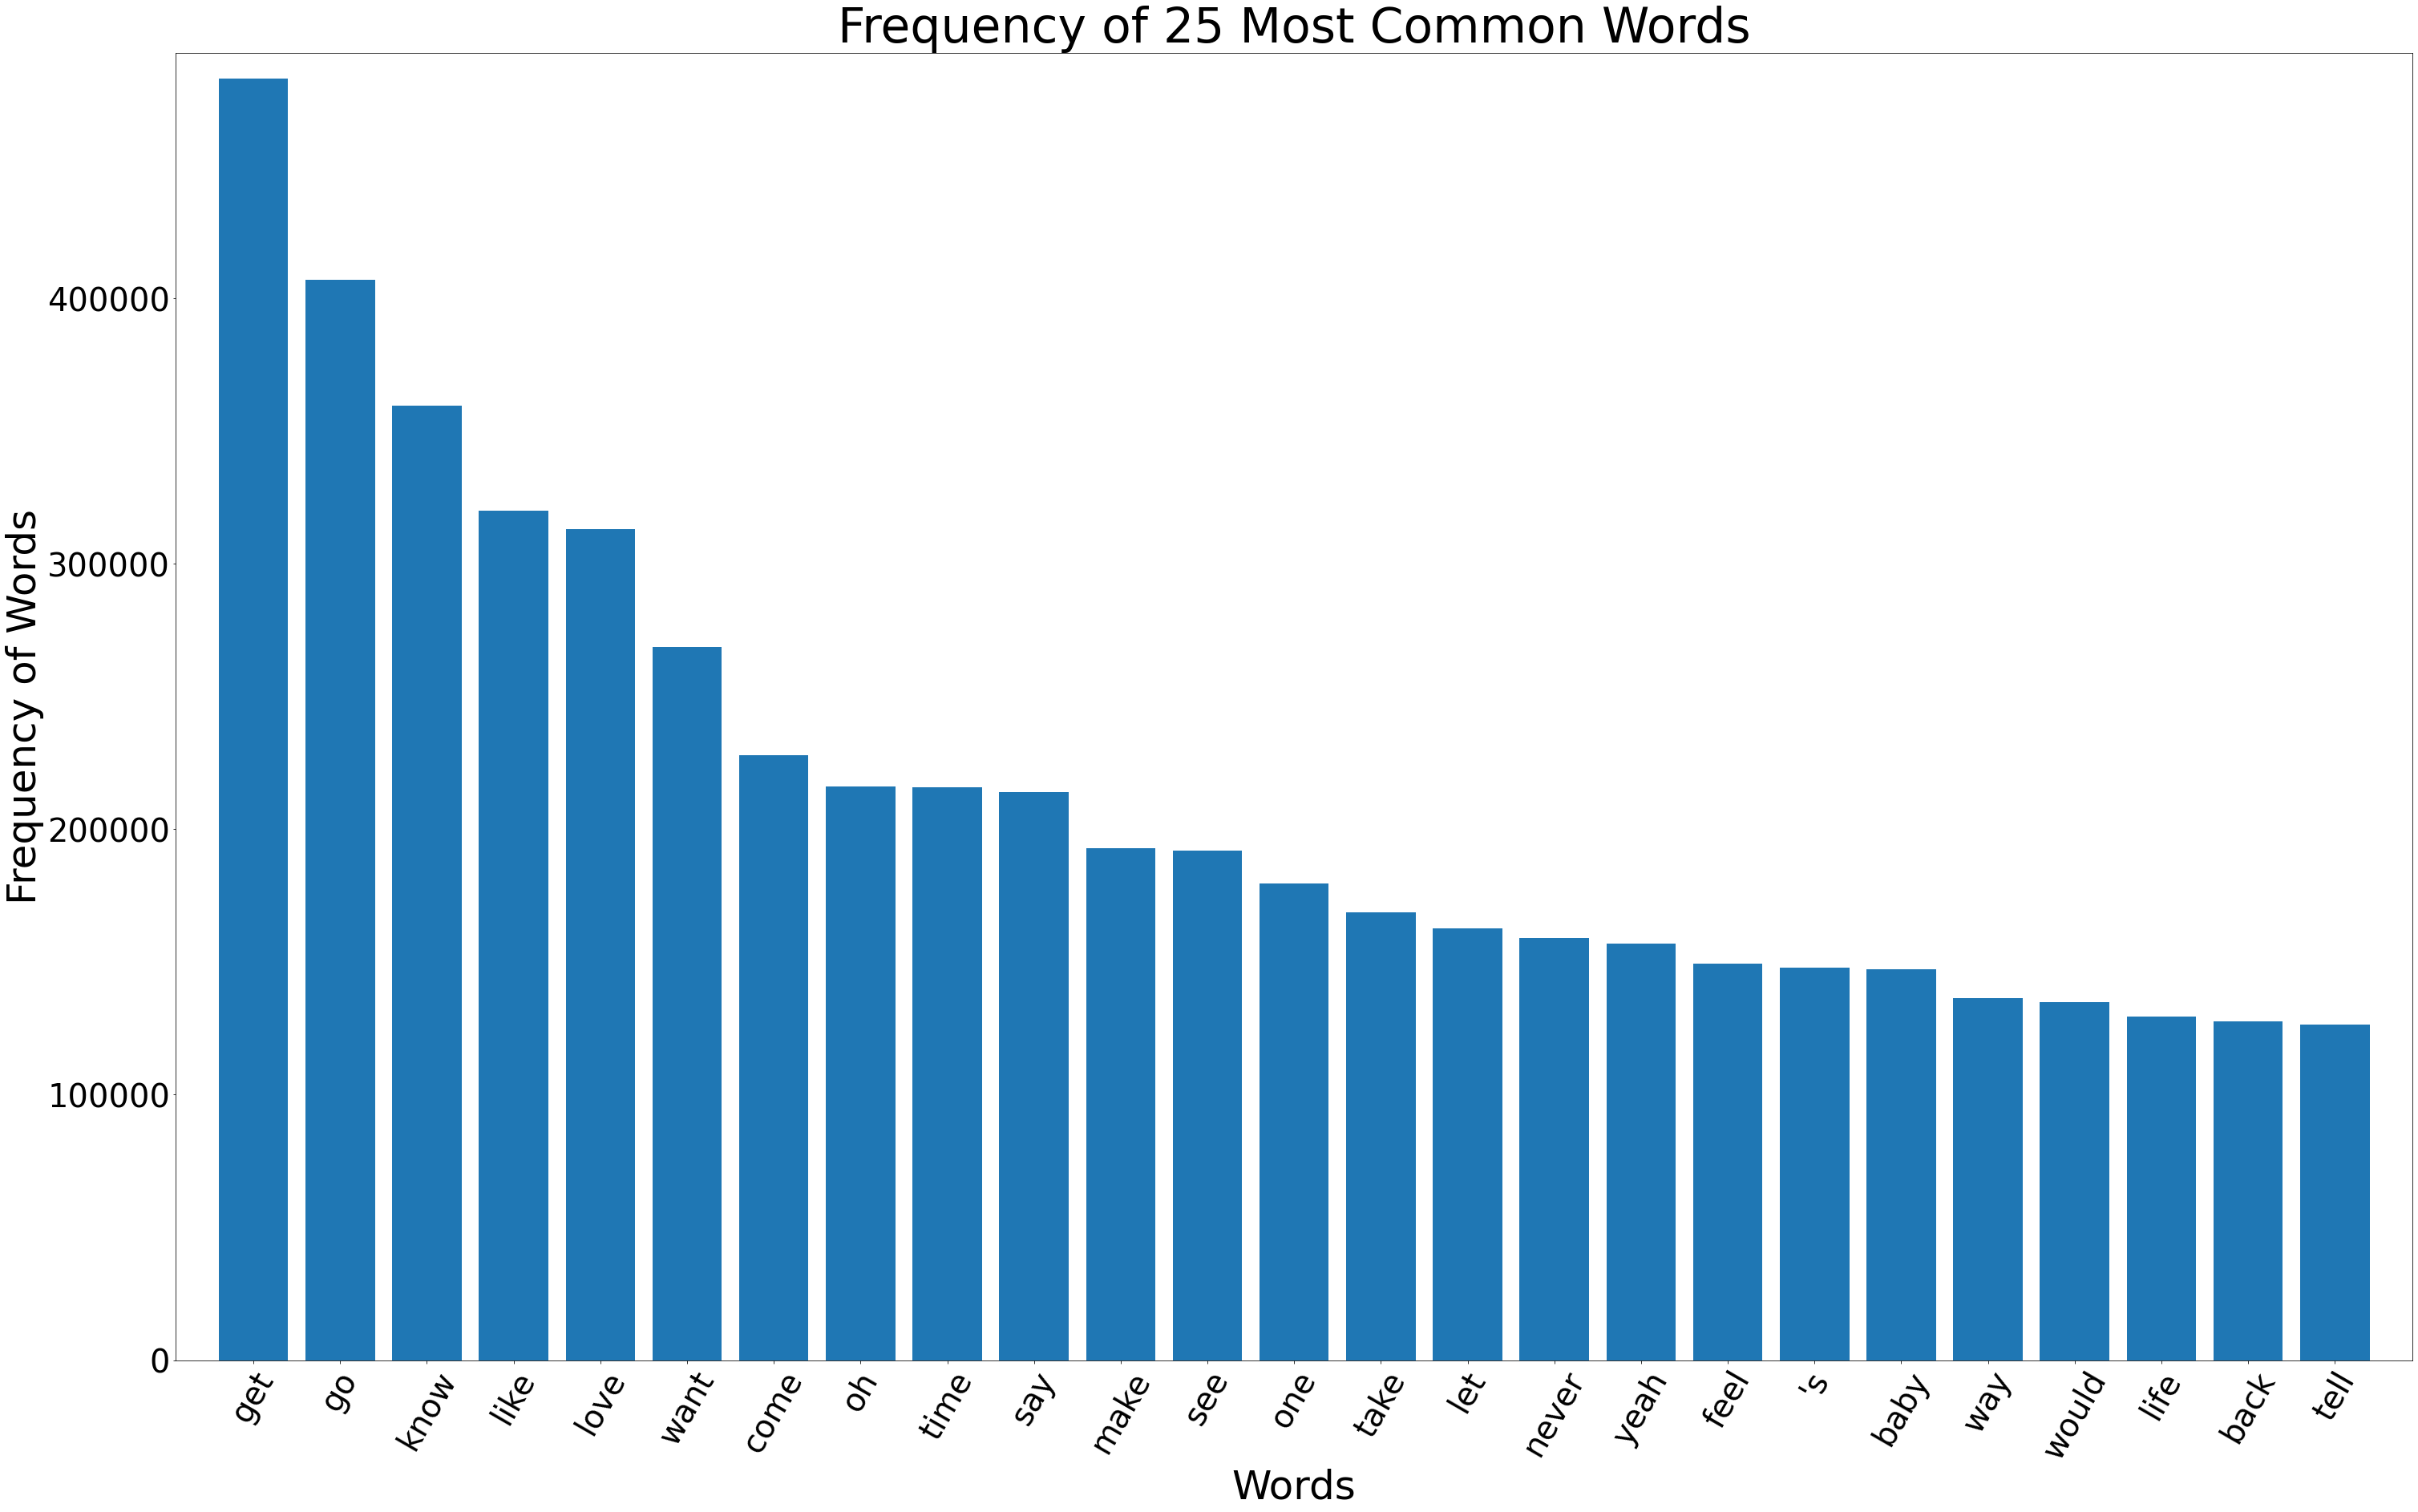

In [17]:
# Term Frequency Analysis: First, we will explore the whole corpus, followed by each individual genre.

# Generating a master list of all words in our corpus
words = songs['lyrics']
allwords = [lyrics for lyrics in songs.lyrics_str]
for wordlist in words:
    allwords += wordlist

# Generate word cloud
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Top 25 words across all genres
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()



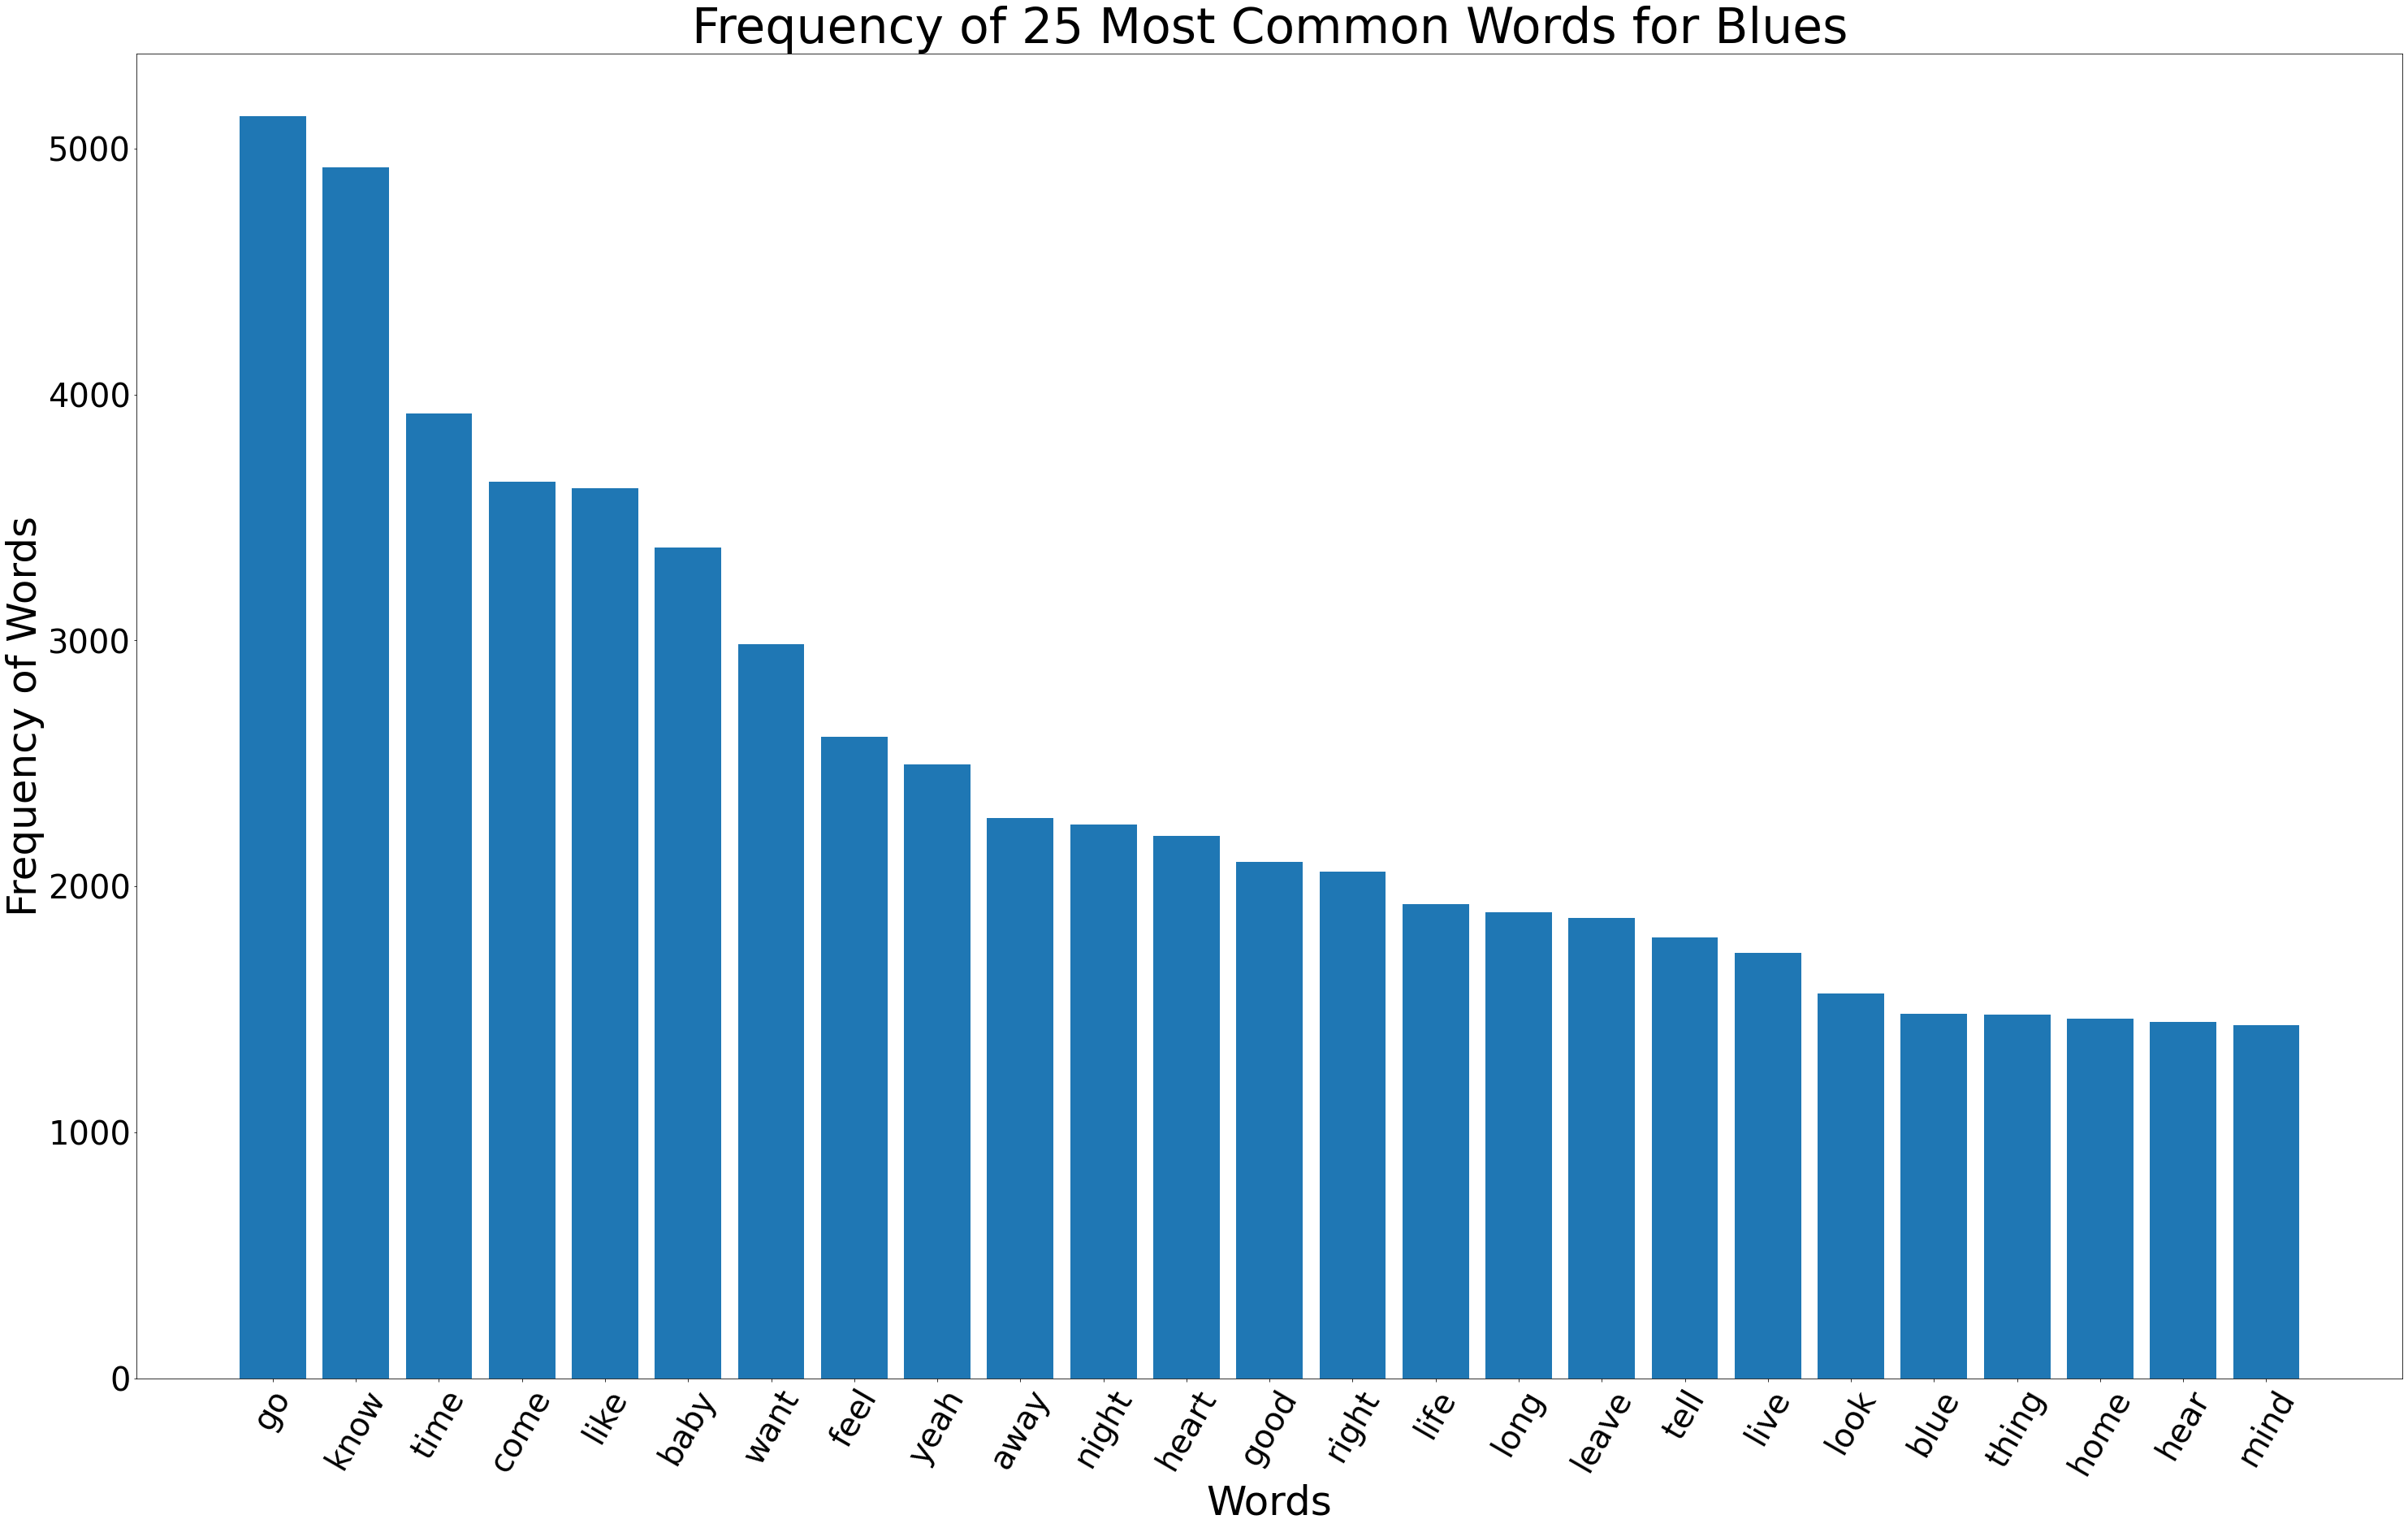

In [27]:
# Now we group by genre (top 25 words)
group_by = songs.groupby('genre')['lyrics_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

def print_freq (genre):
    group_by_0 = group_by.loc[genre]
    words0 = list(zip(*group_by_0))[0]
    freq0 = list(zip(*group_by_0))[1]
    plt.figure(figsize=(50,30))
    plt.bar(words0, freq0)
    plt.xlabel('Words', fontsize=50)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=60, fontsize=40)
    plt.title(f'Frequency of 25 Most Common Words for {genre}', fontsize=60)
    plt.show()

print_freq('Blues')

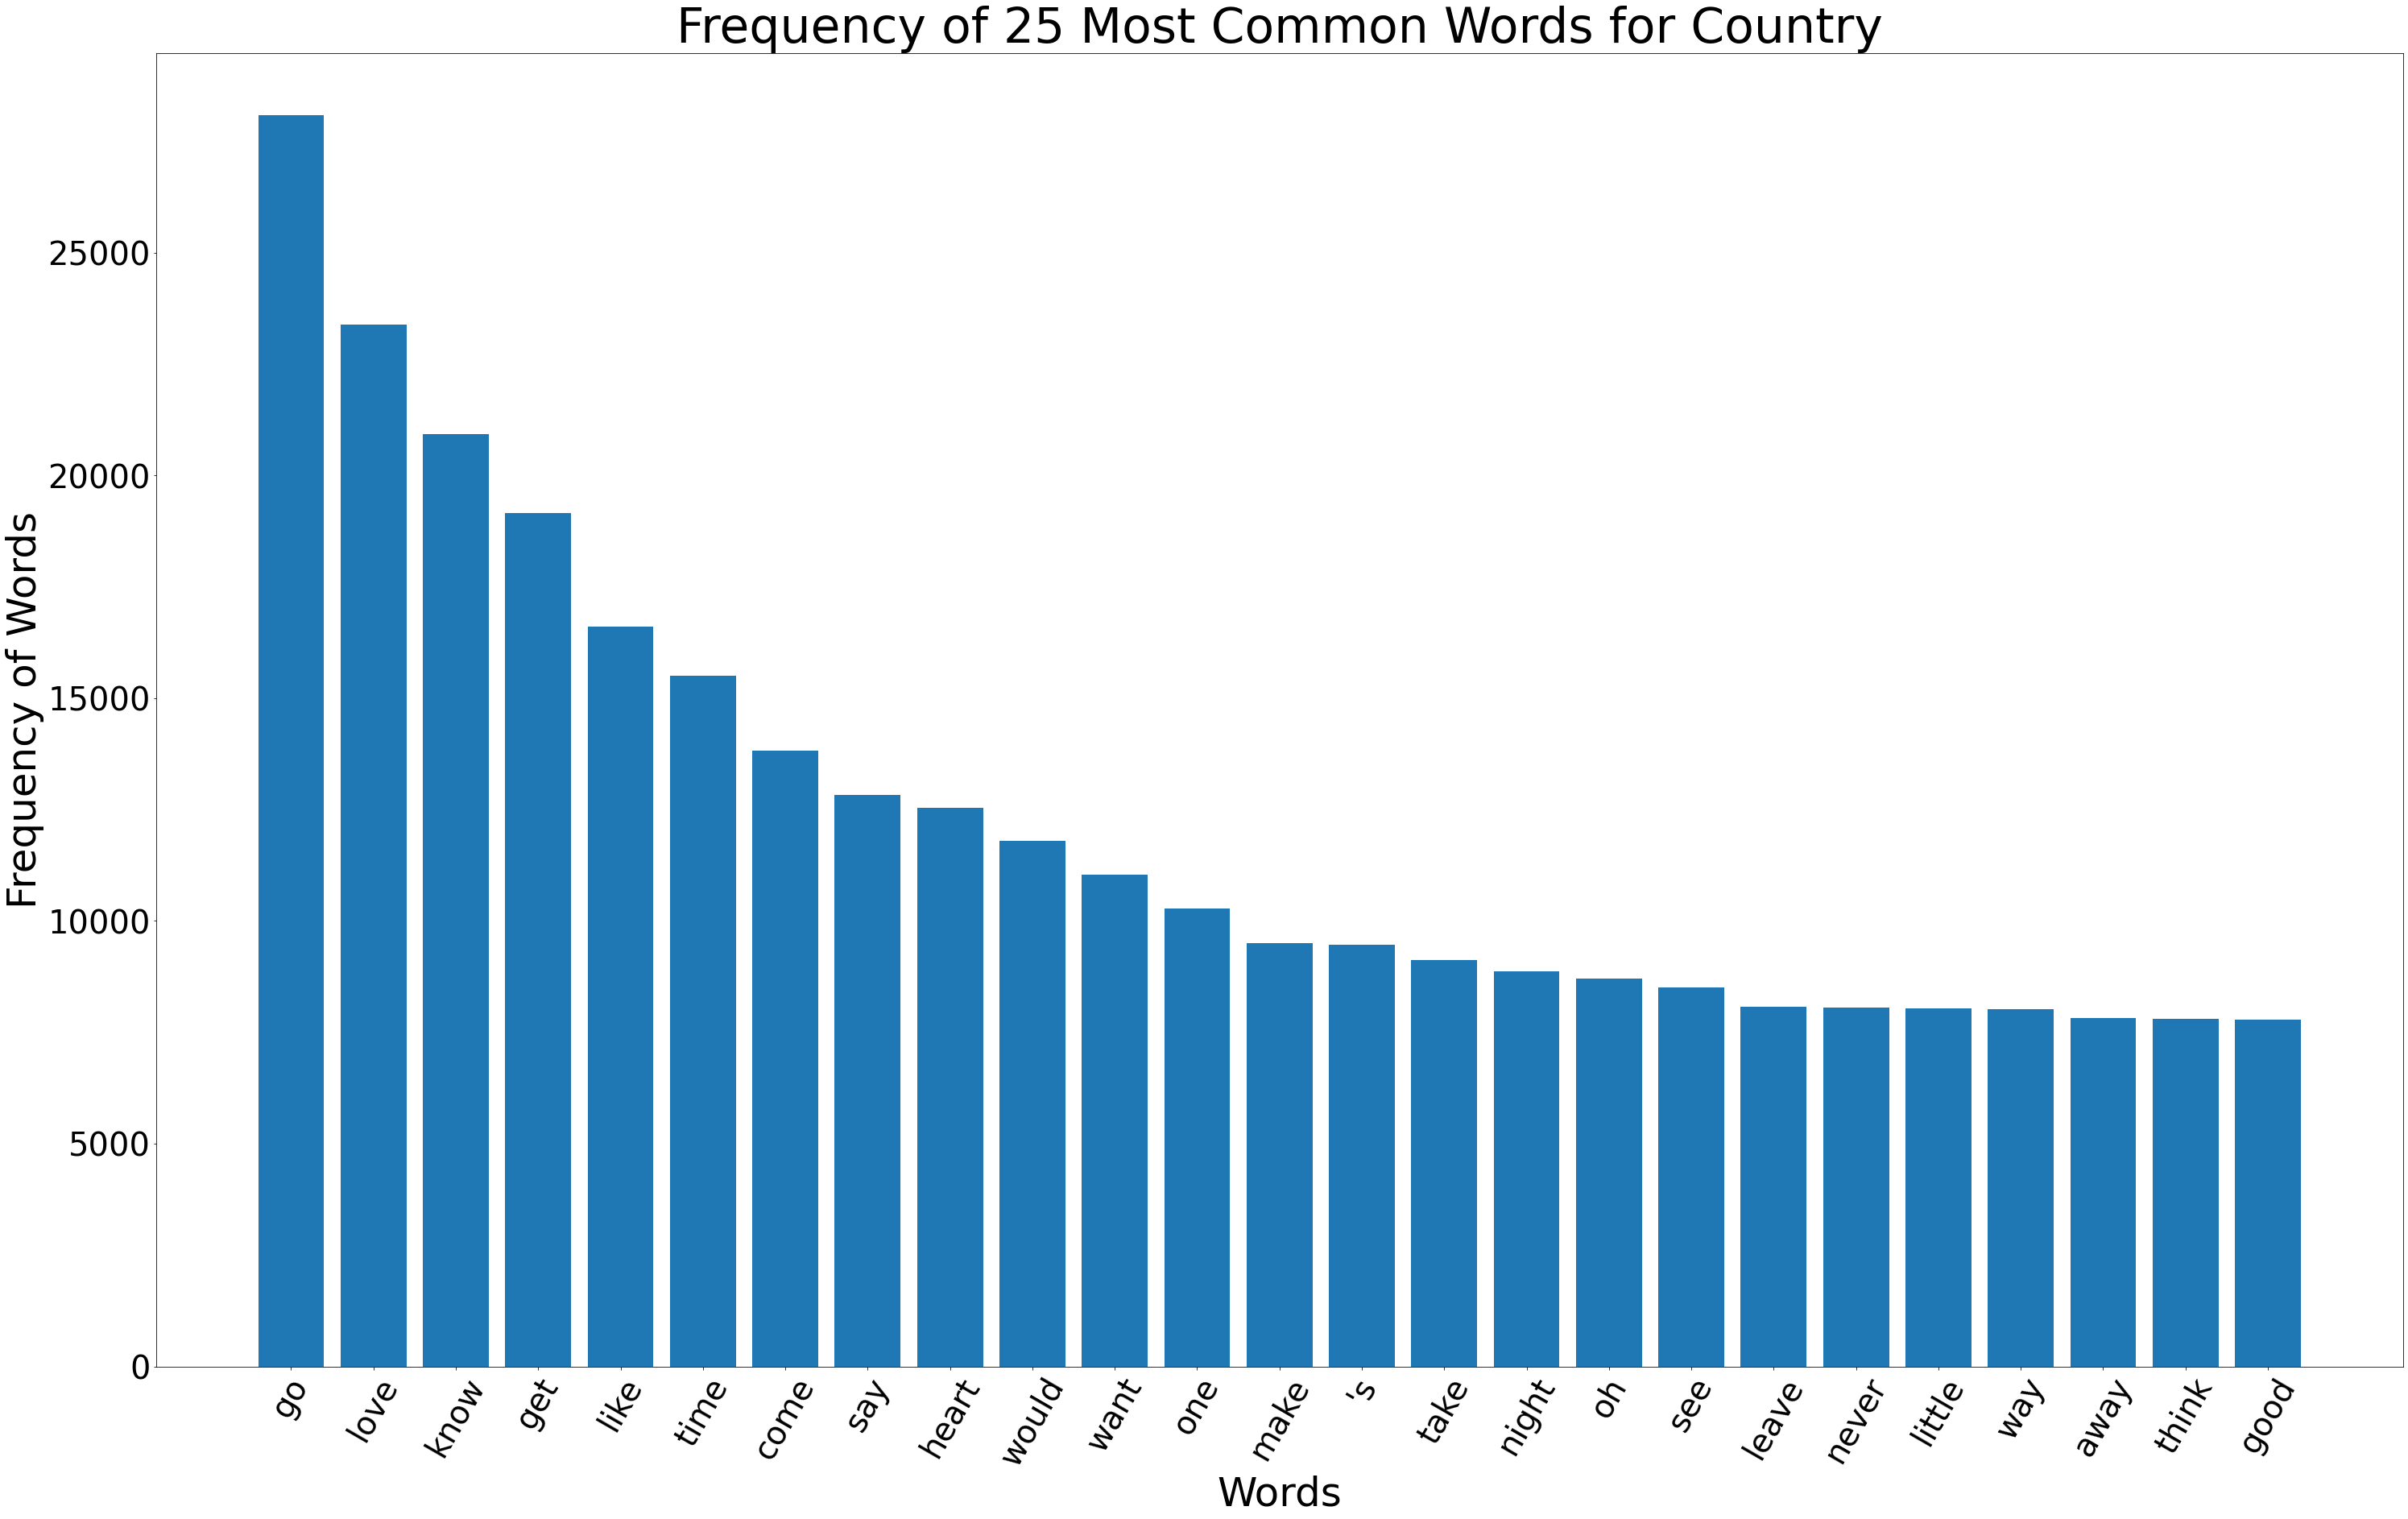

In [28]:
print_freq('Country')

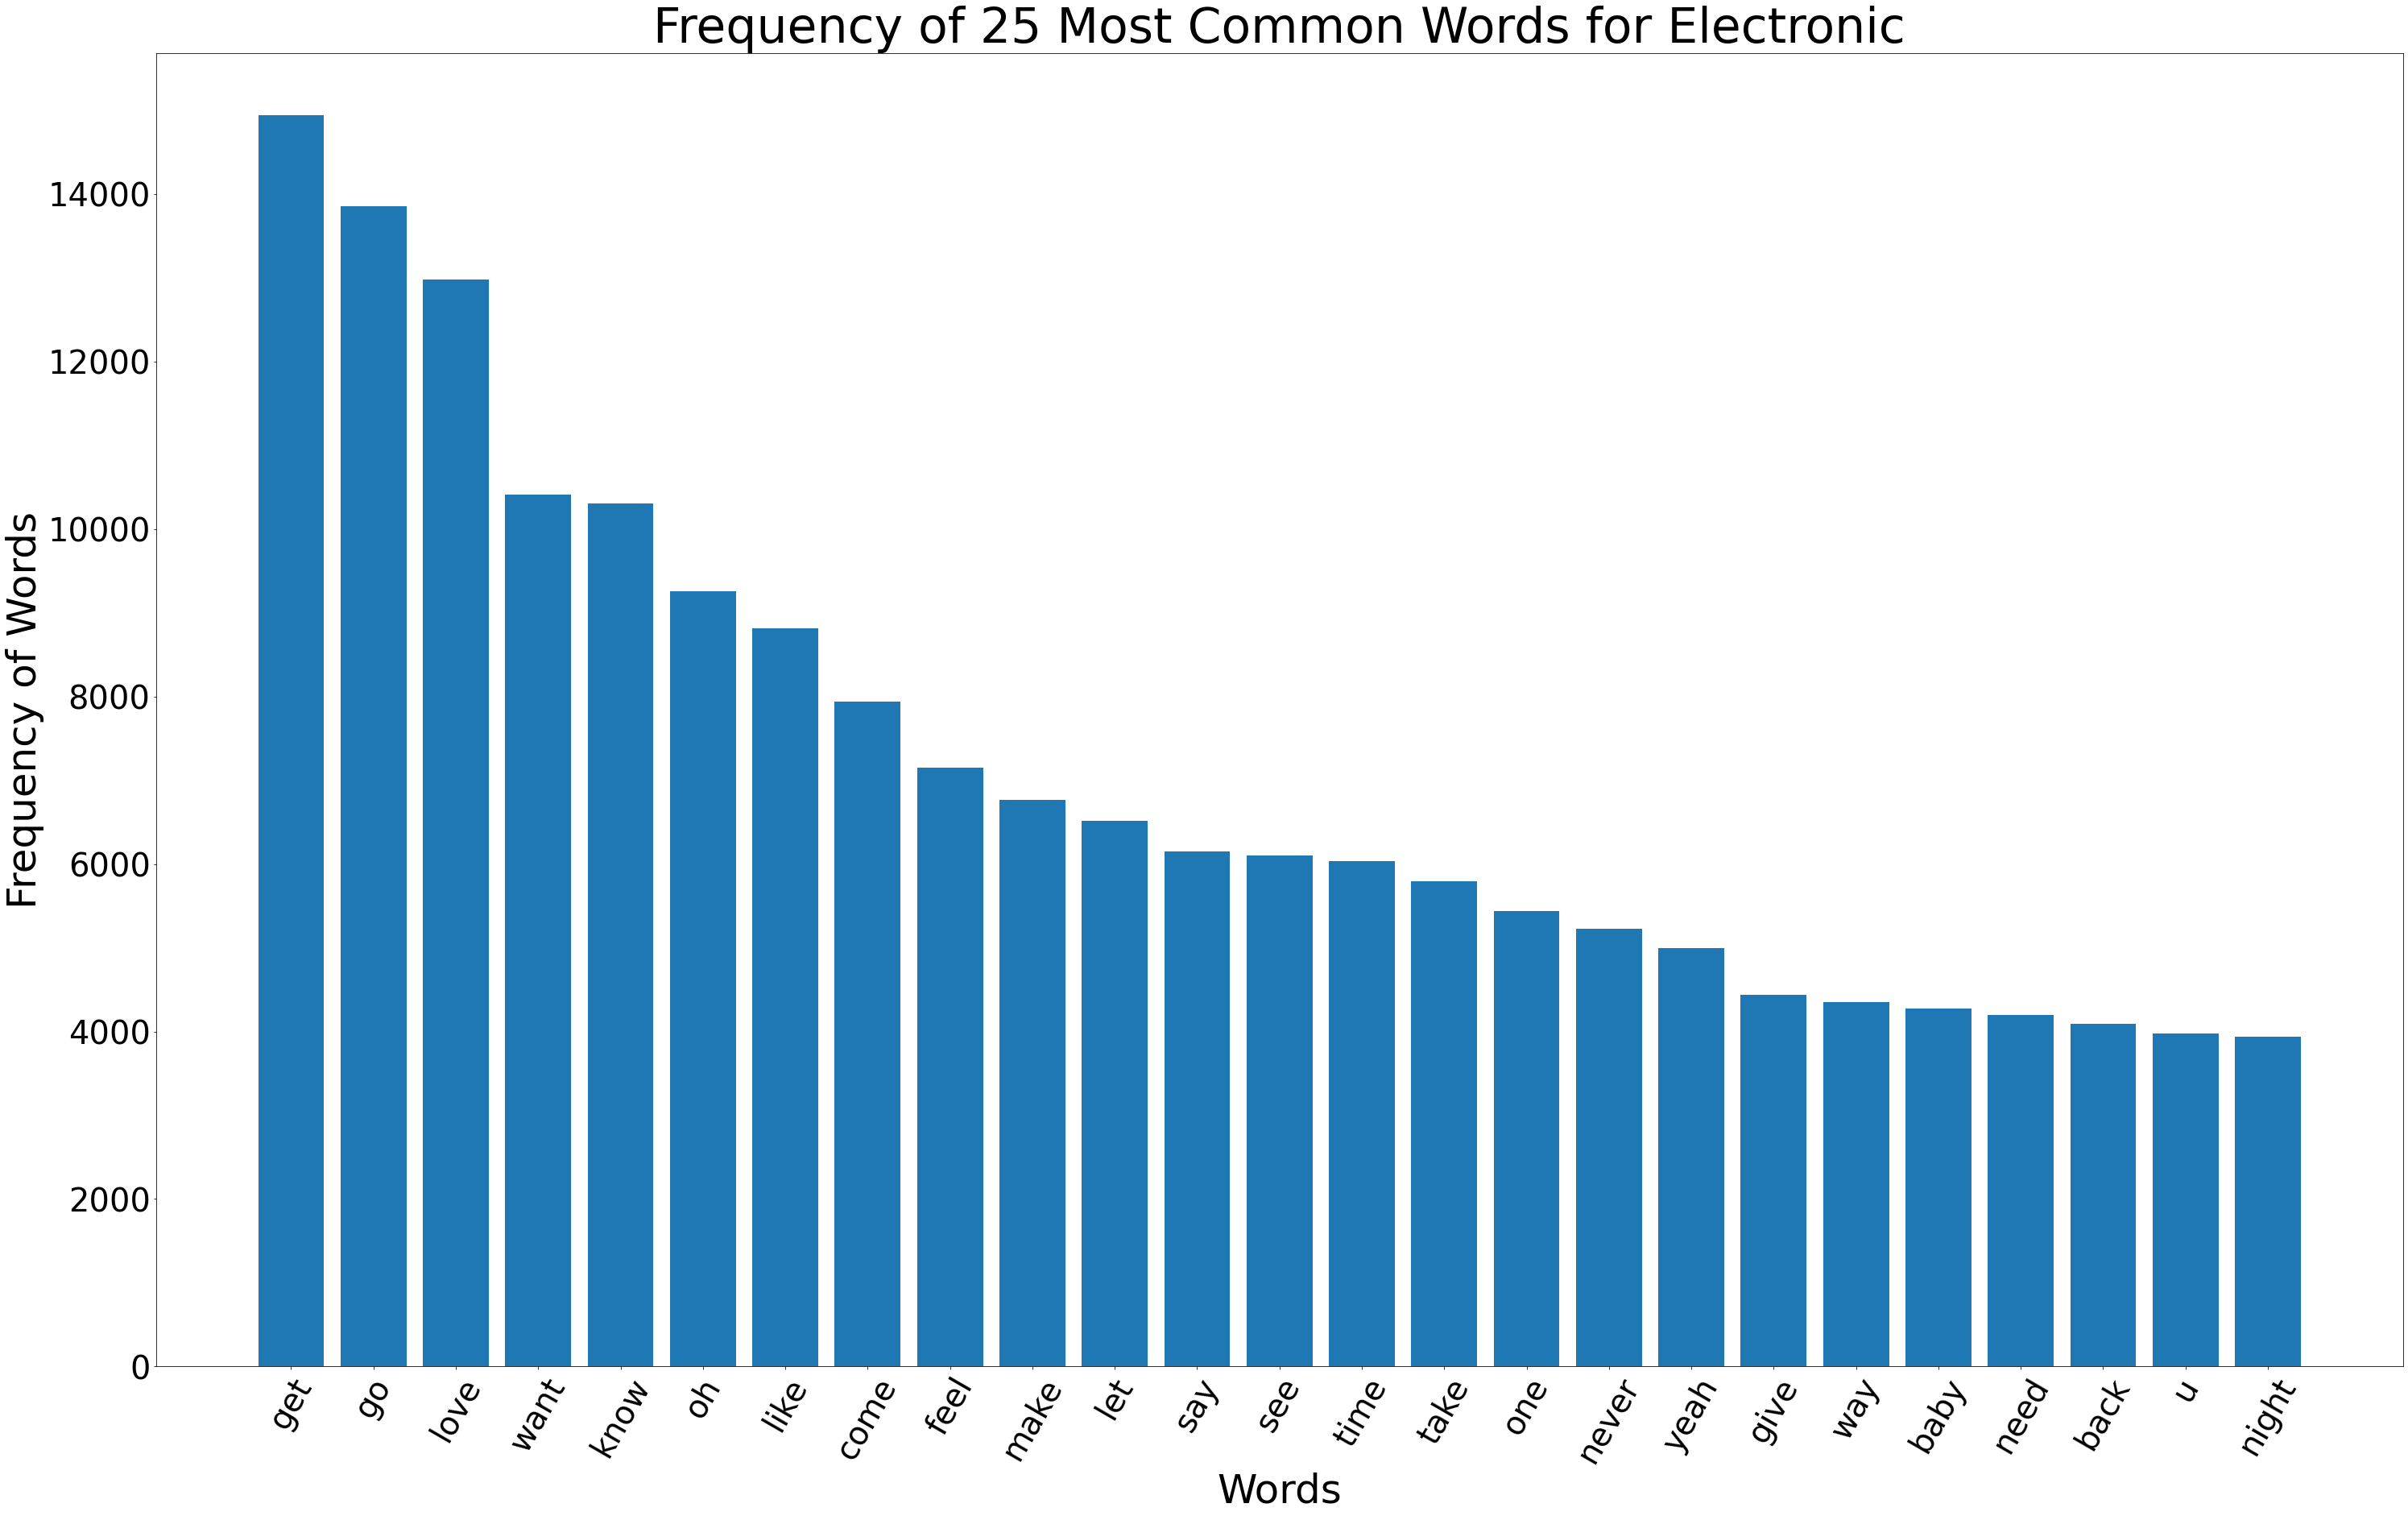

In [29]:
print_freq('Electronic')

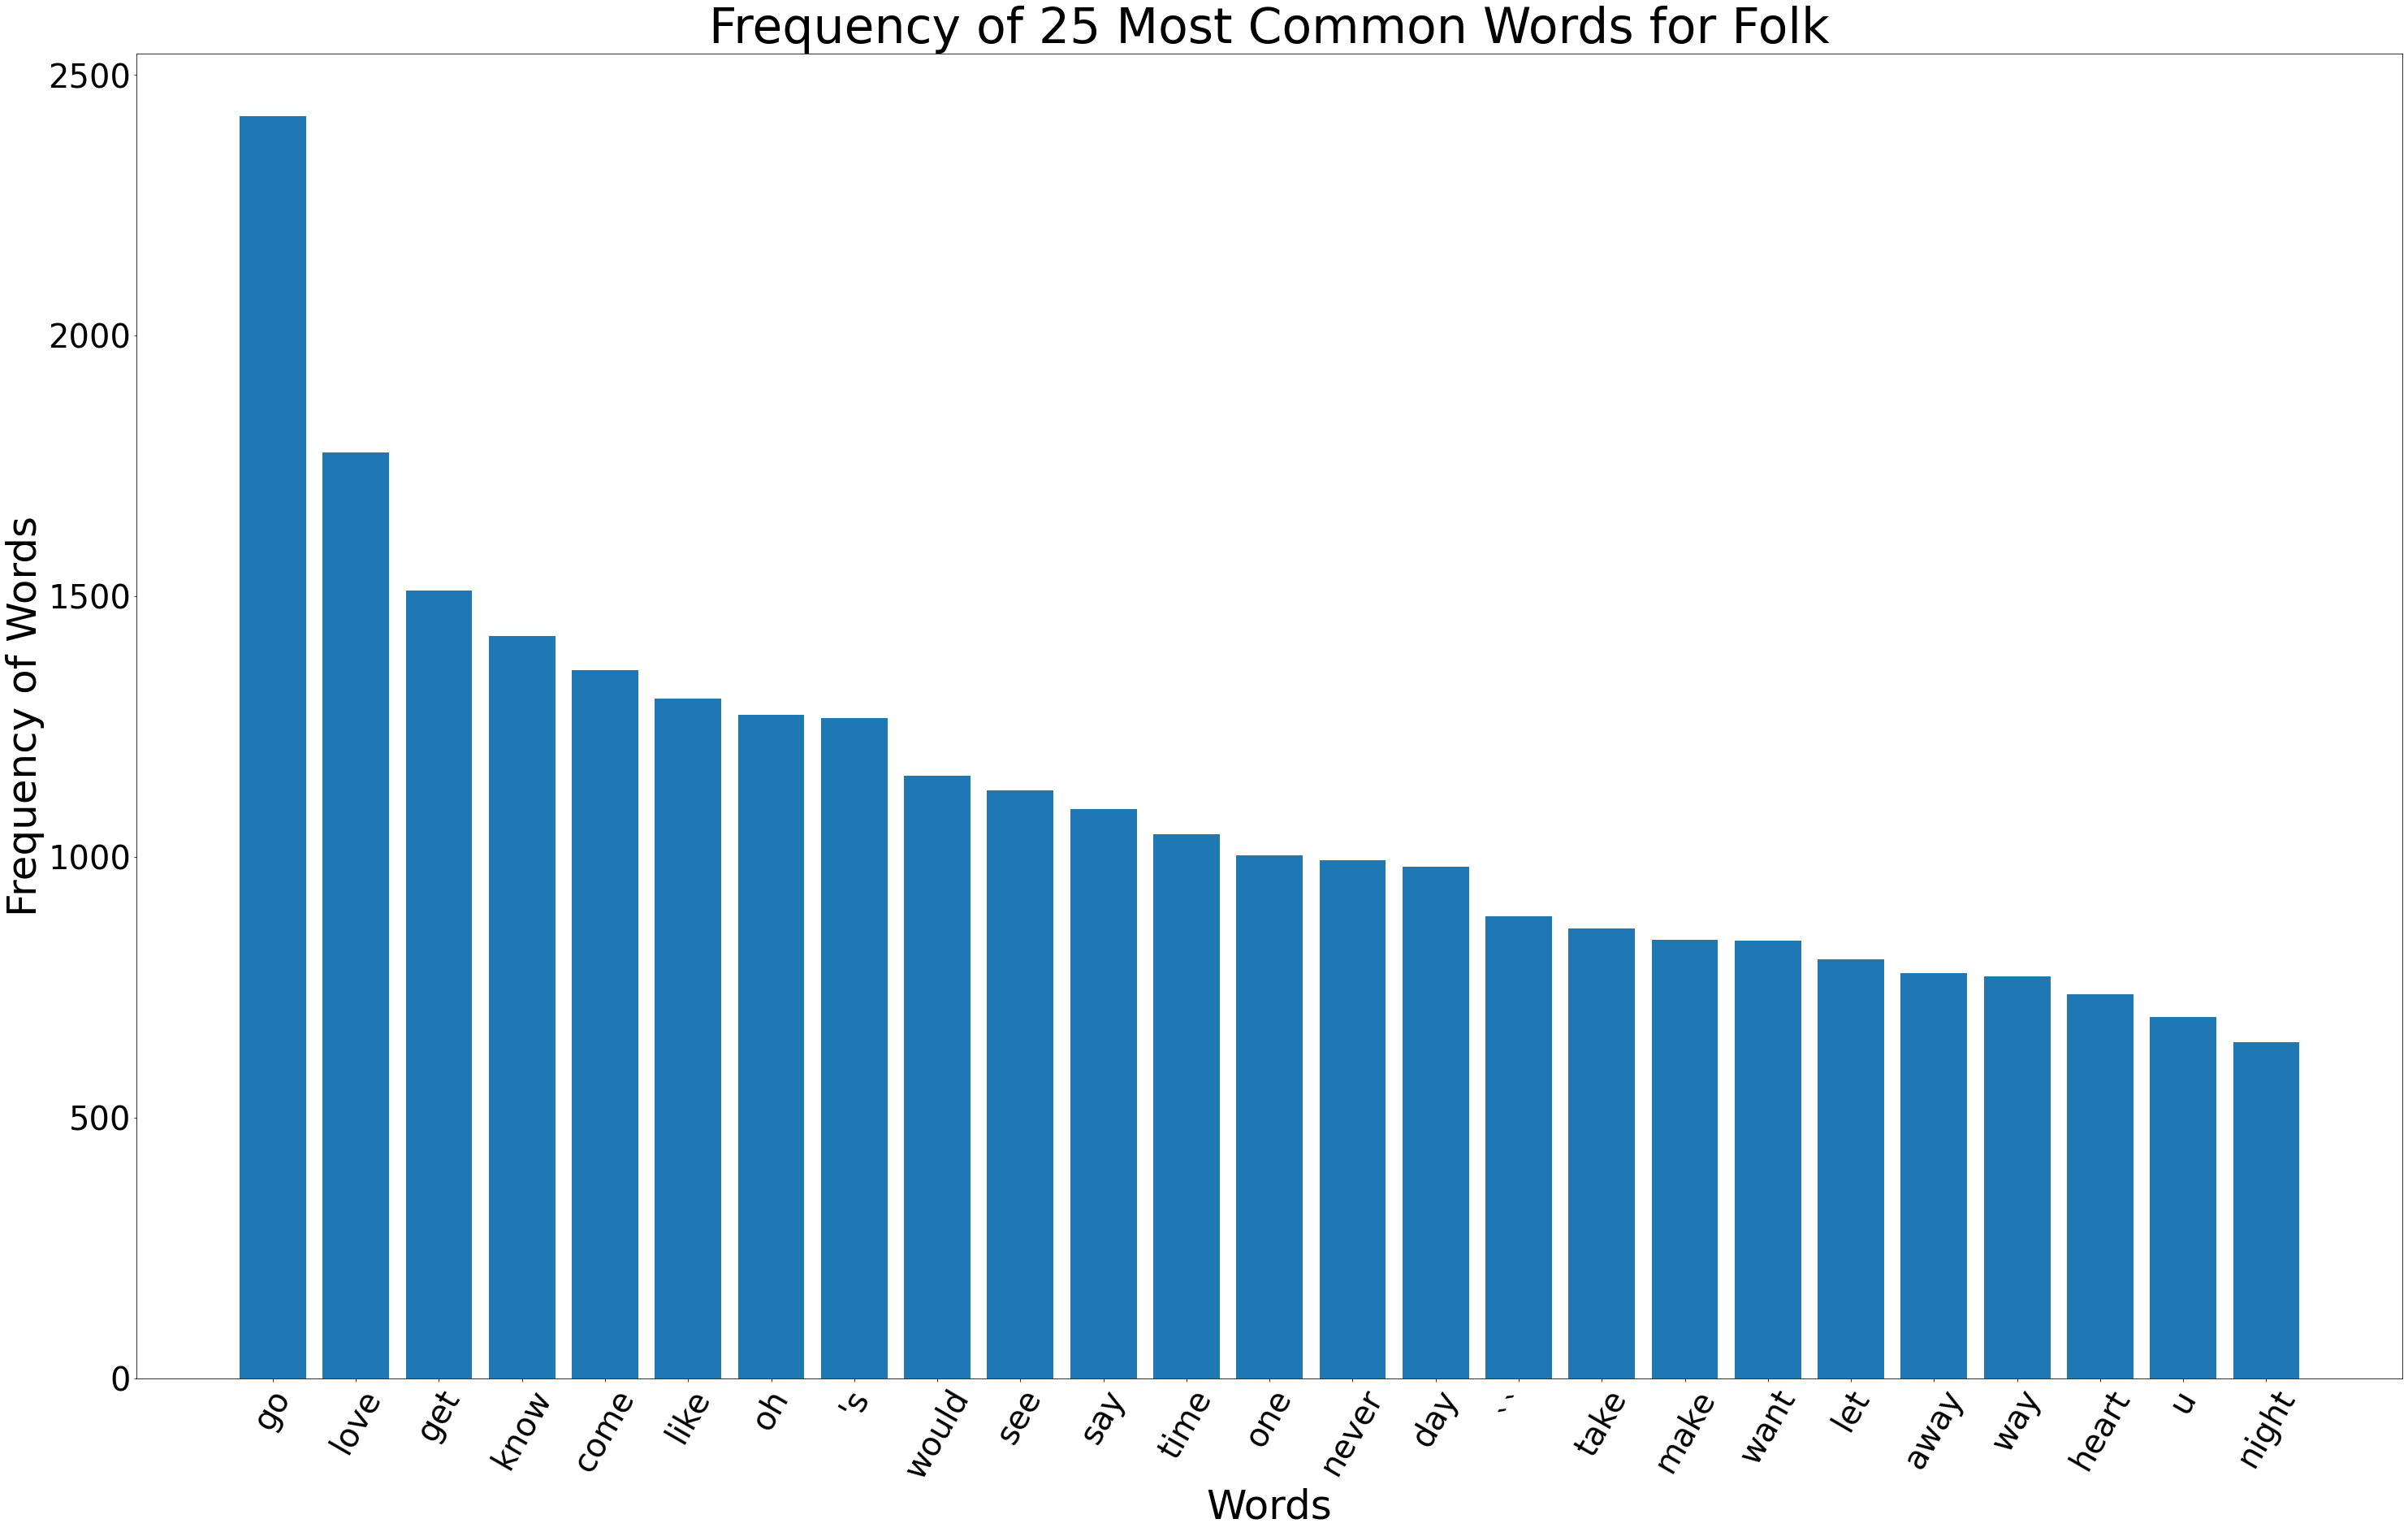

In [30]:
print_freq('Folk')

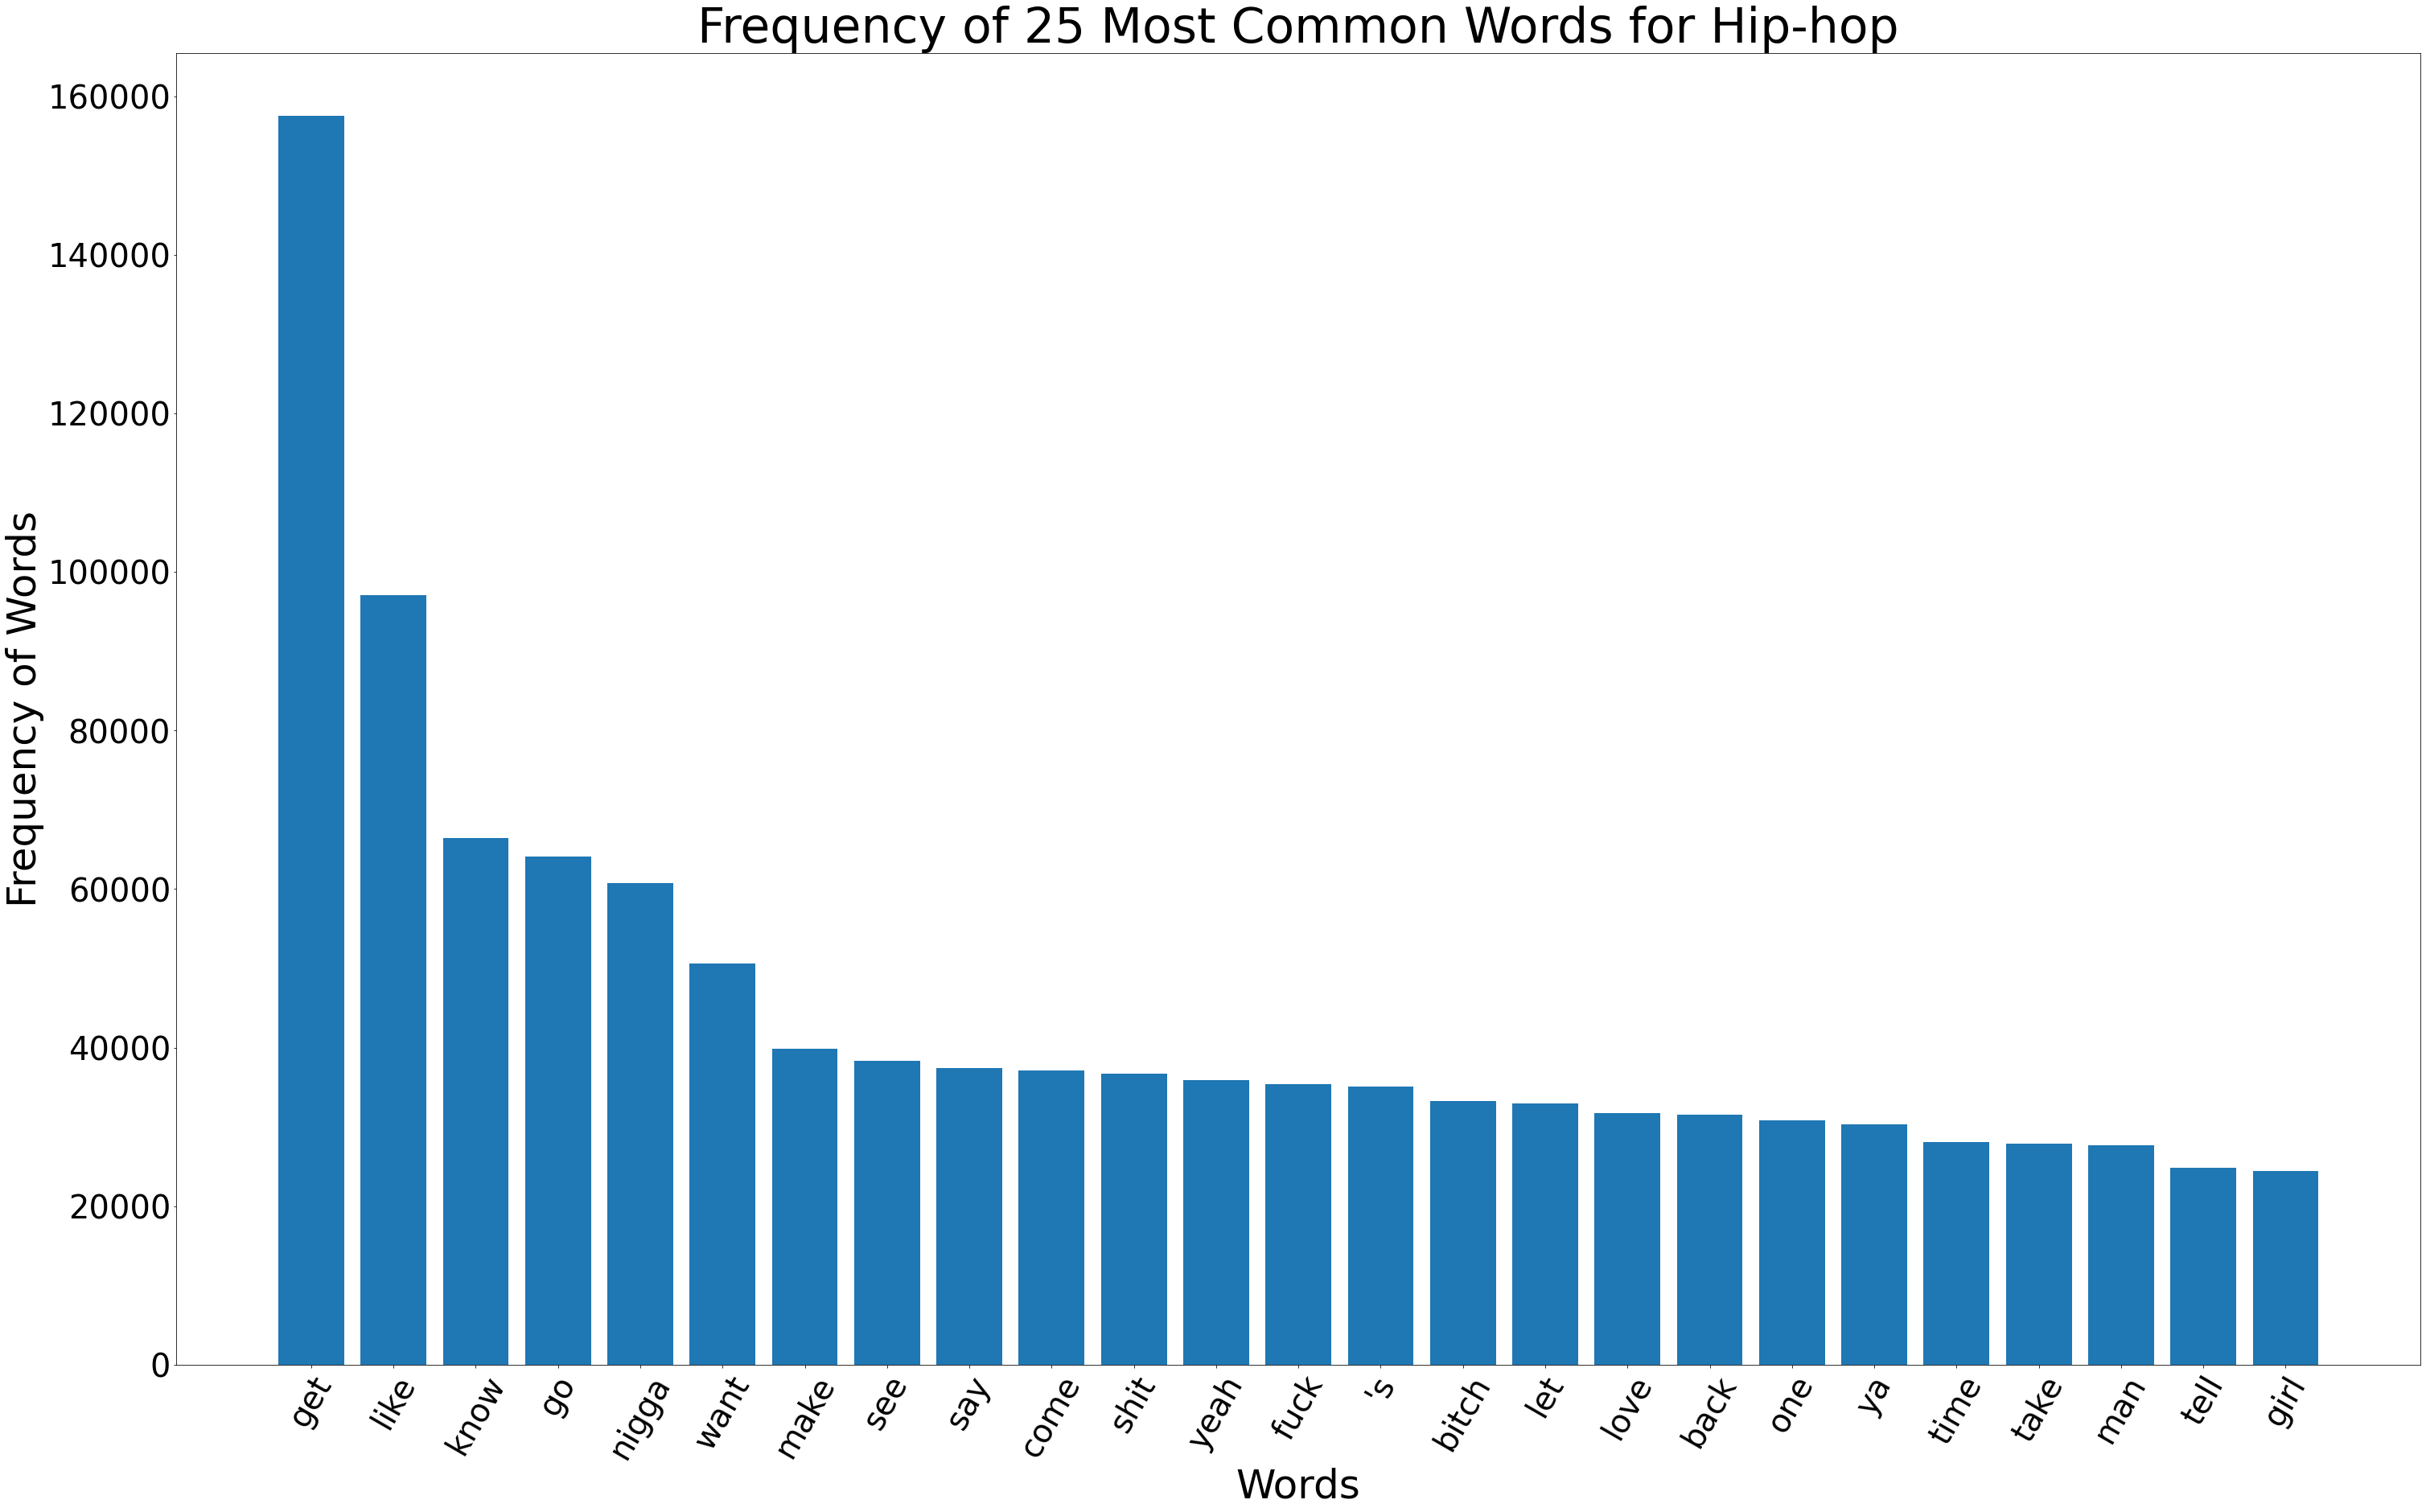

In [31]:
print_freq('Hip-hop')

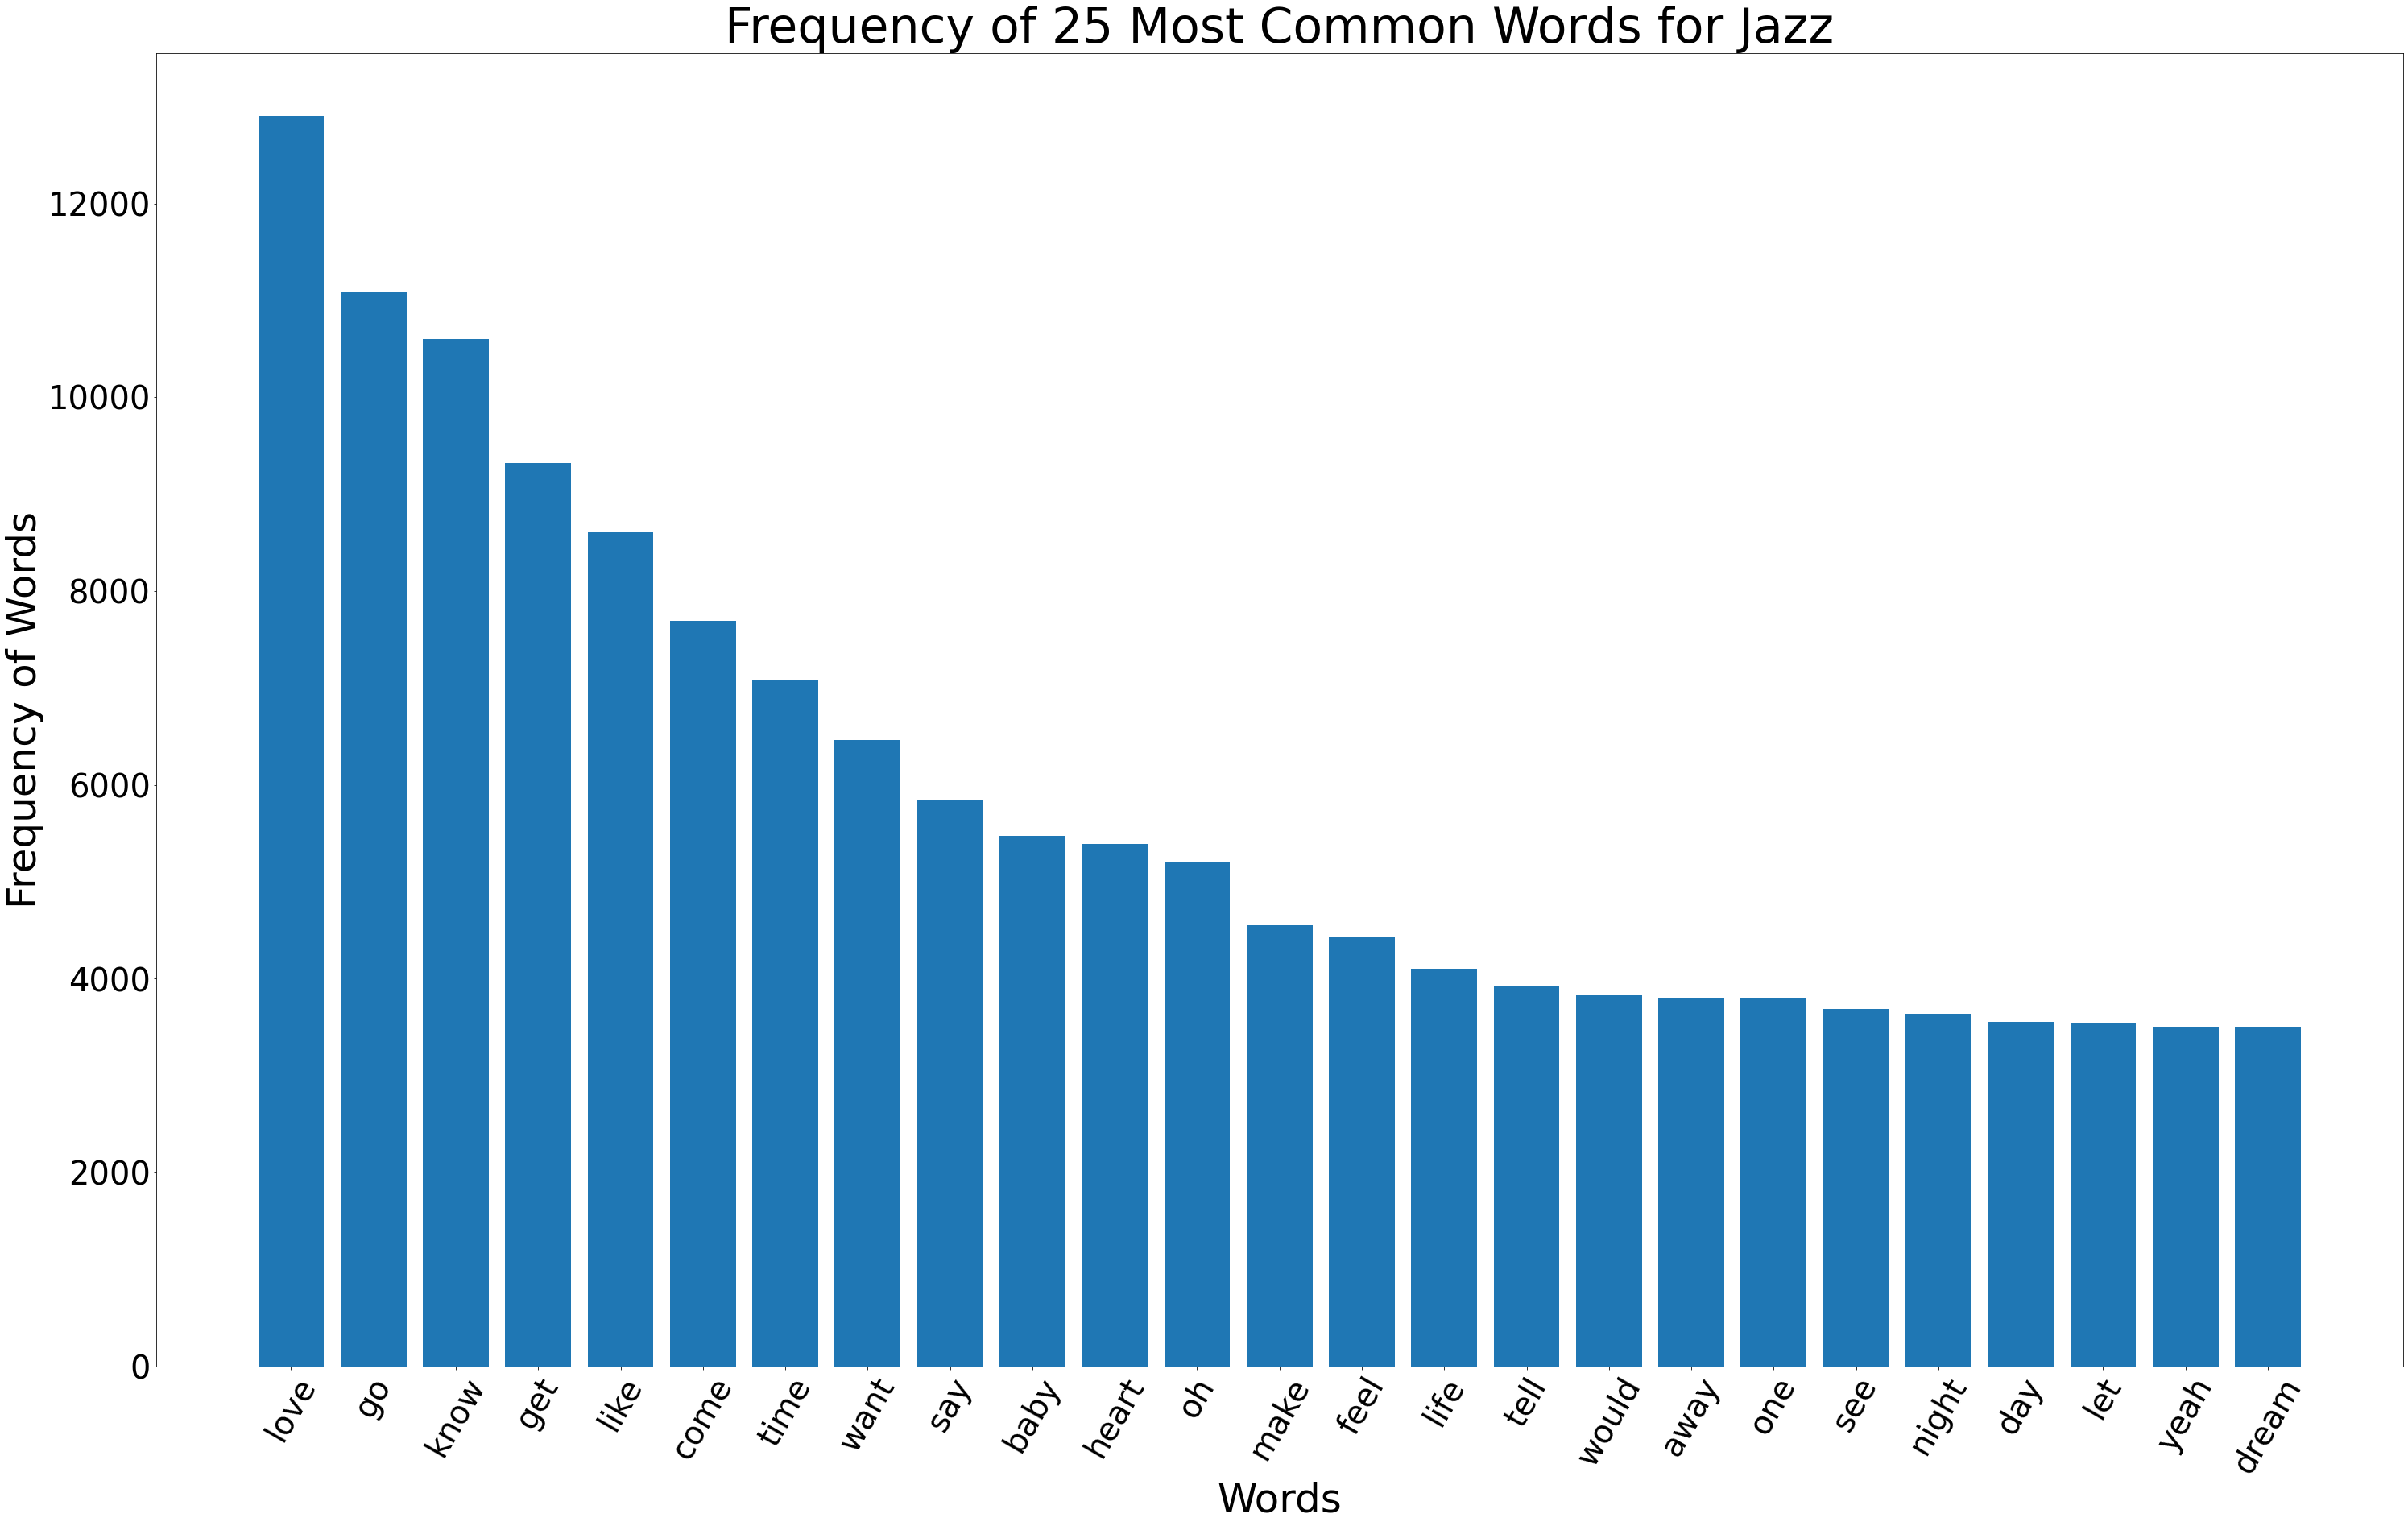

In [32]:
print_freq('Jazz')

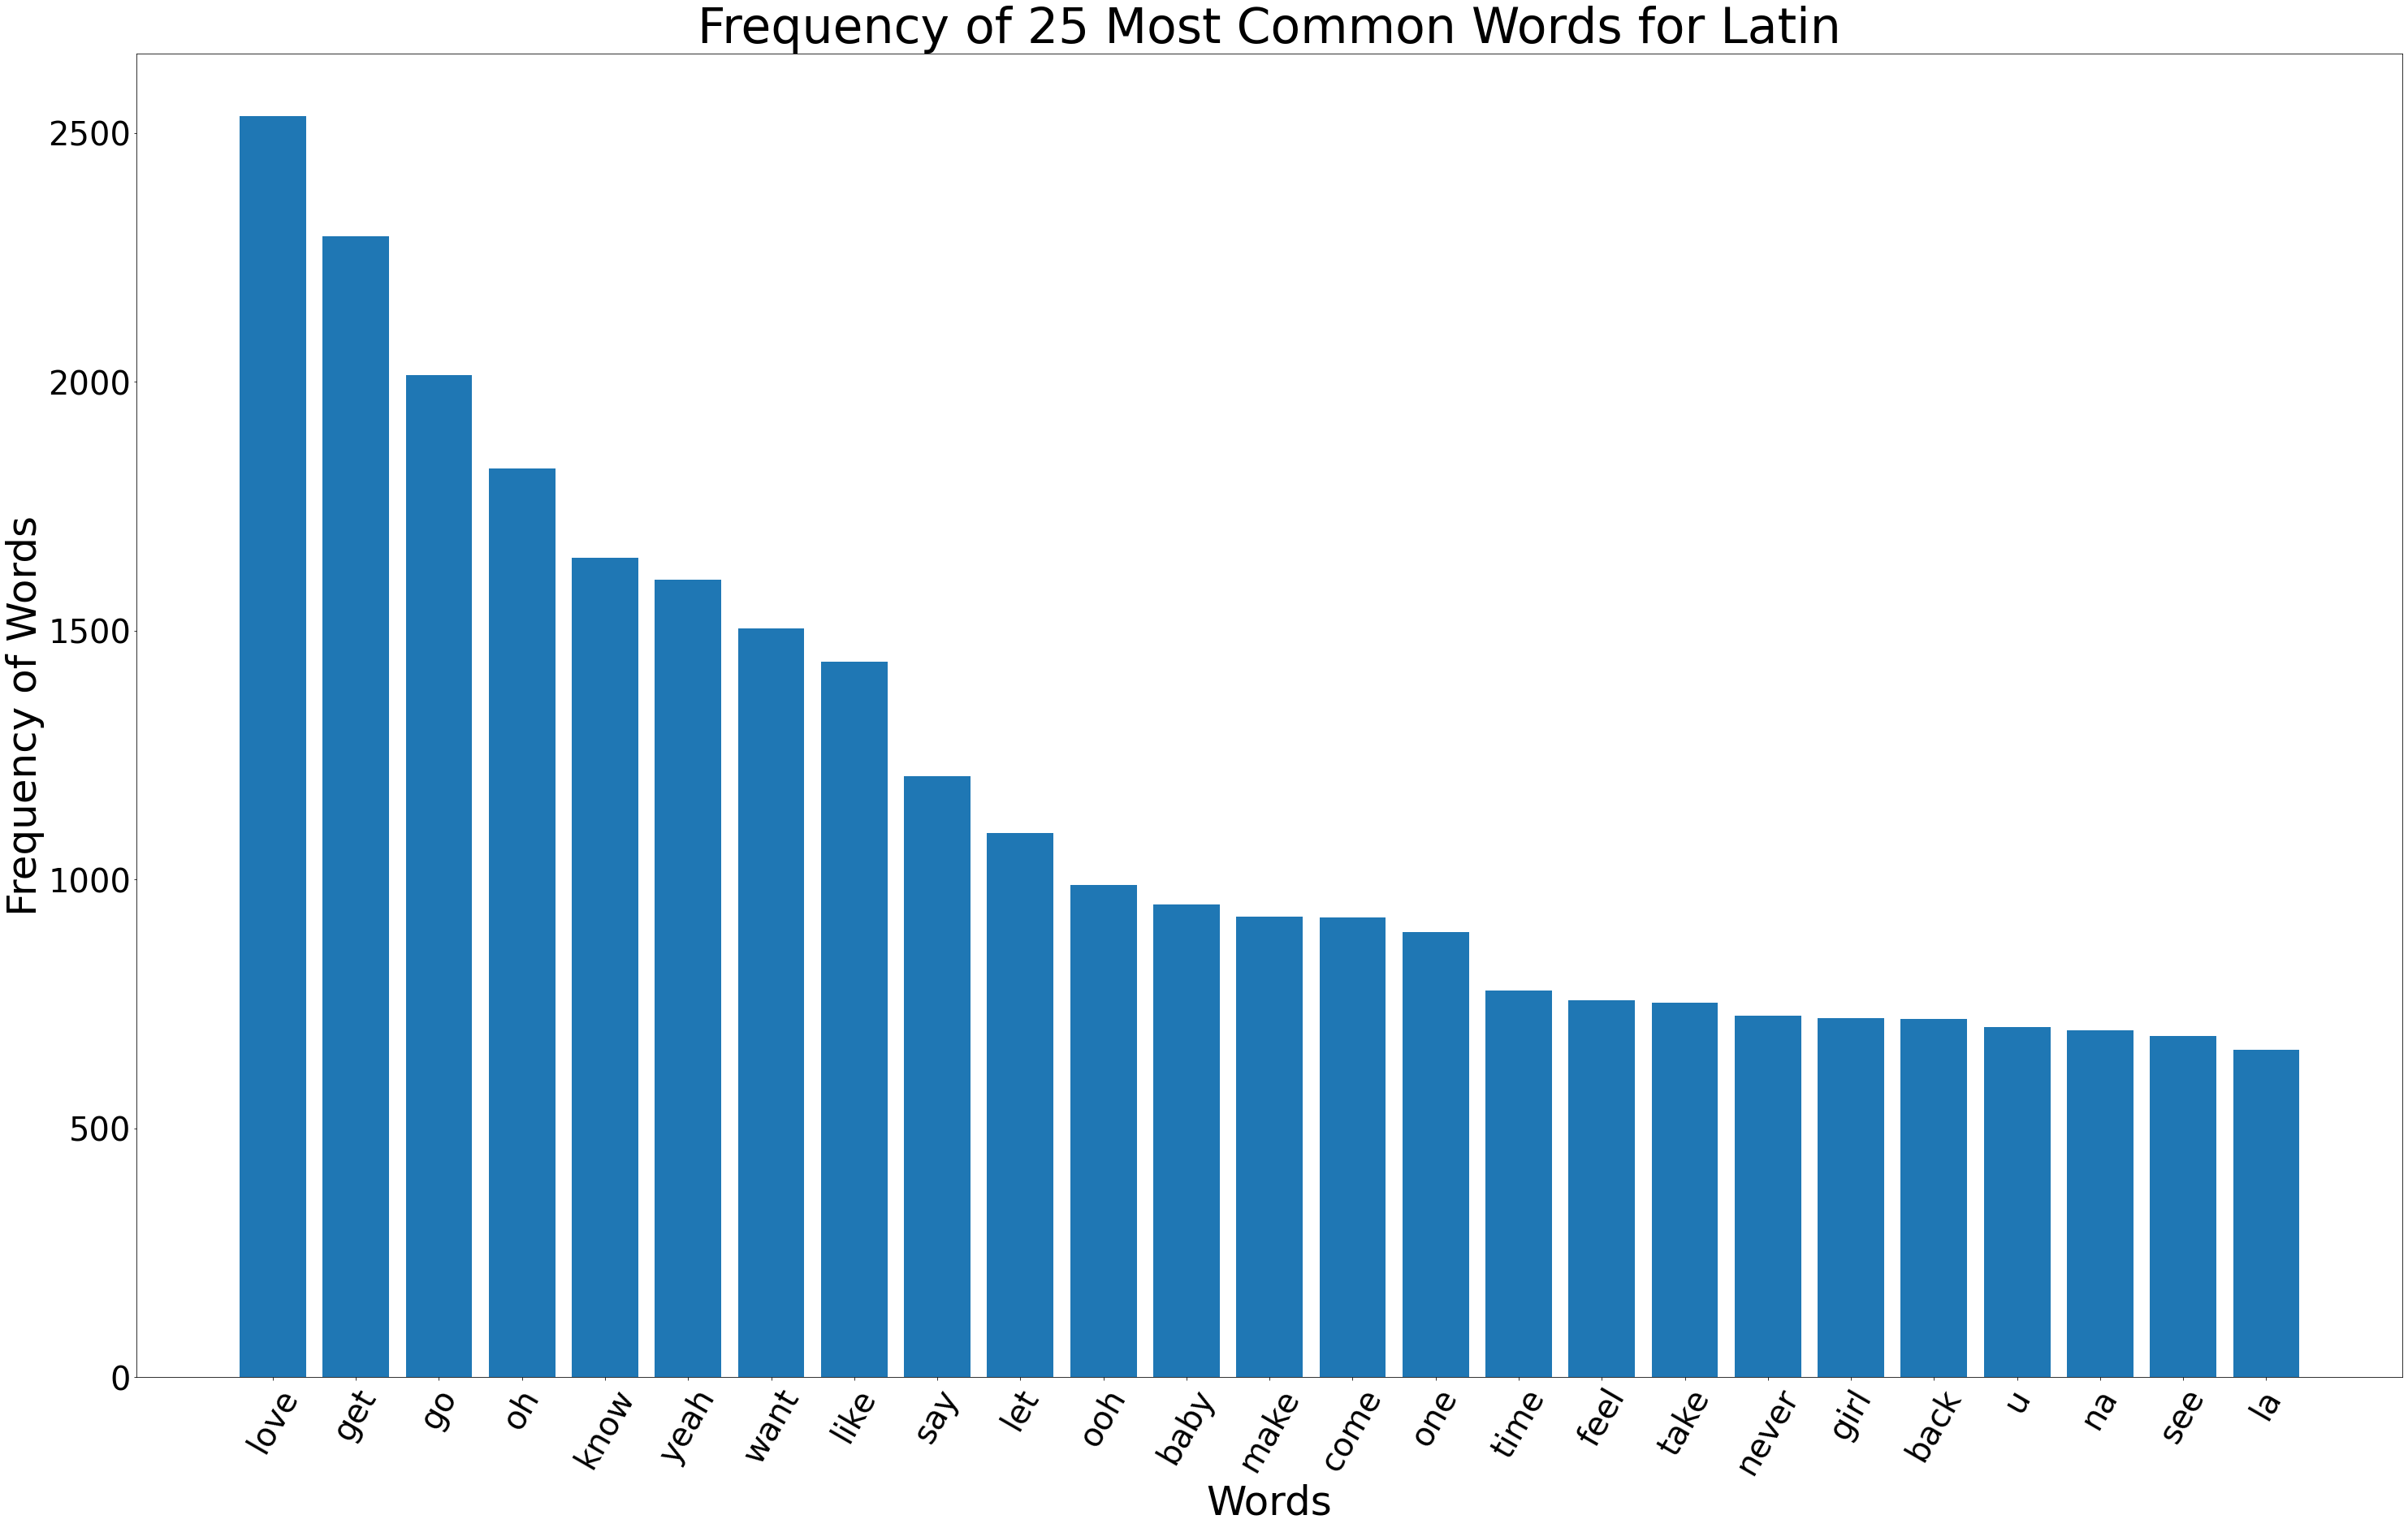

In [33]:
print_freq('Latin')

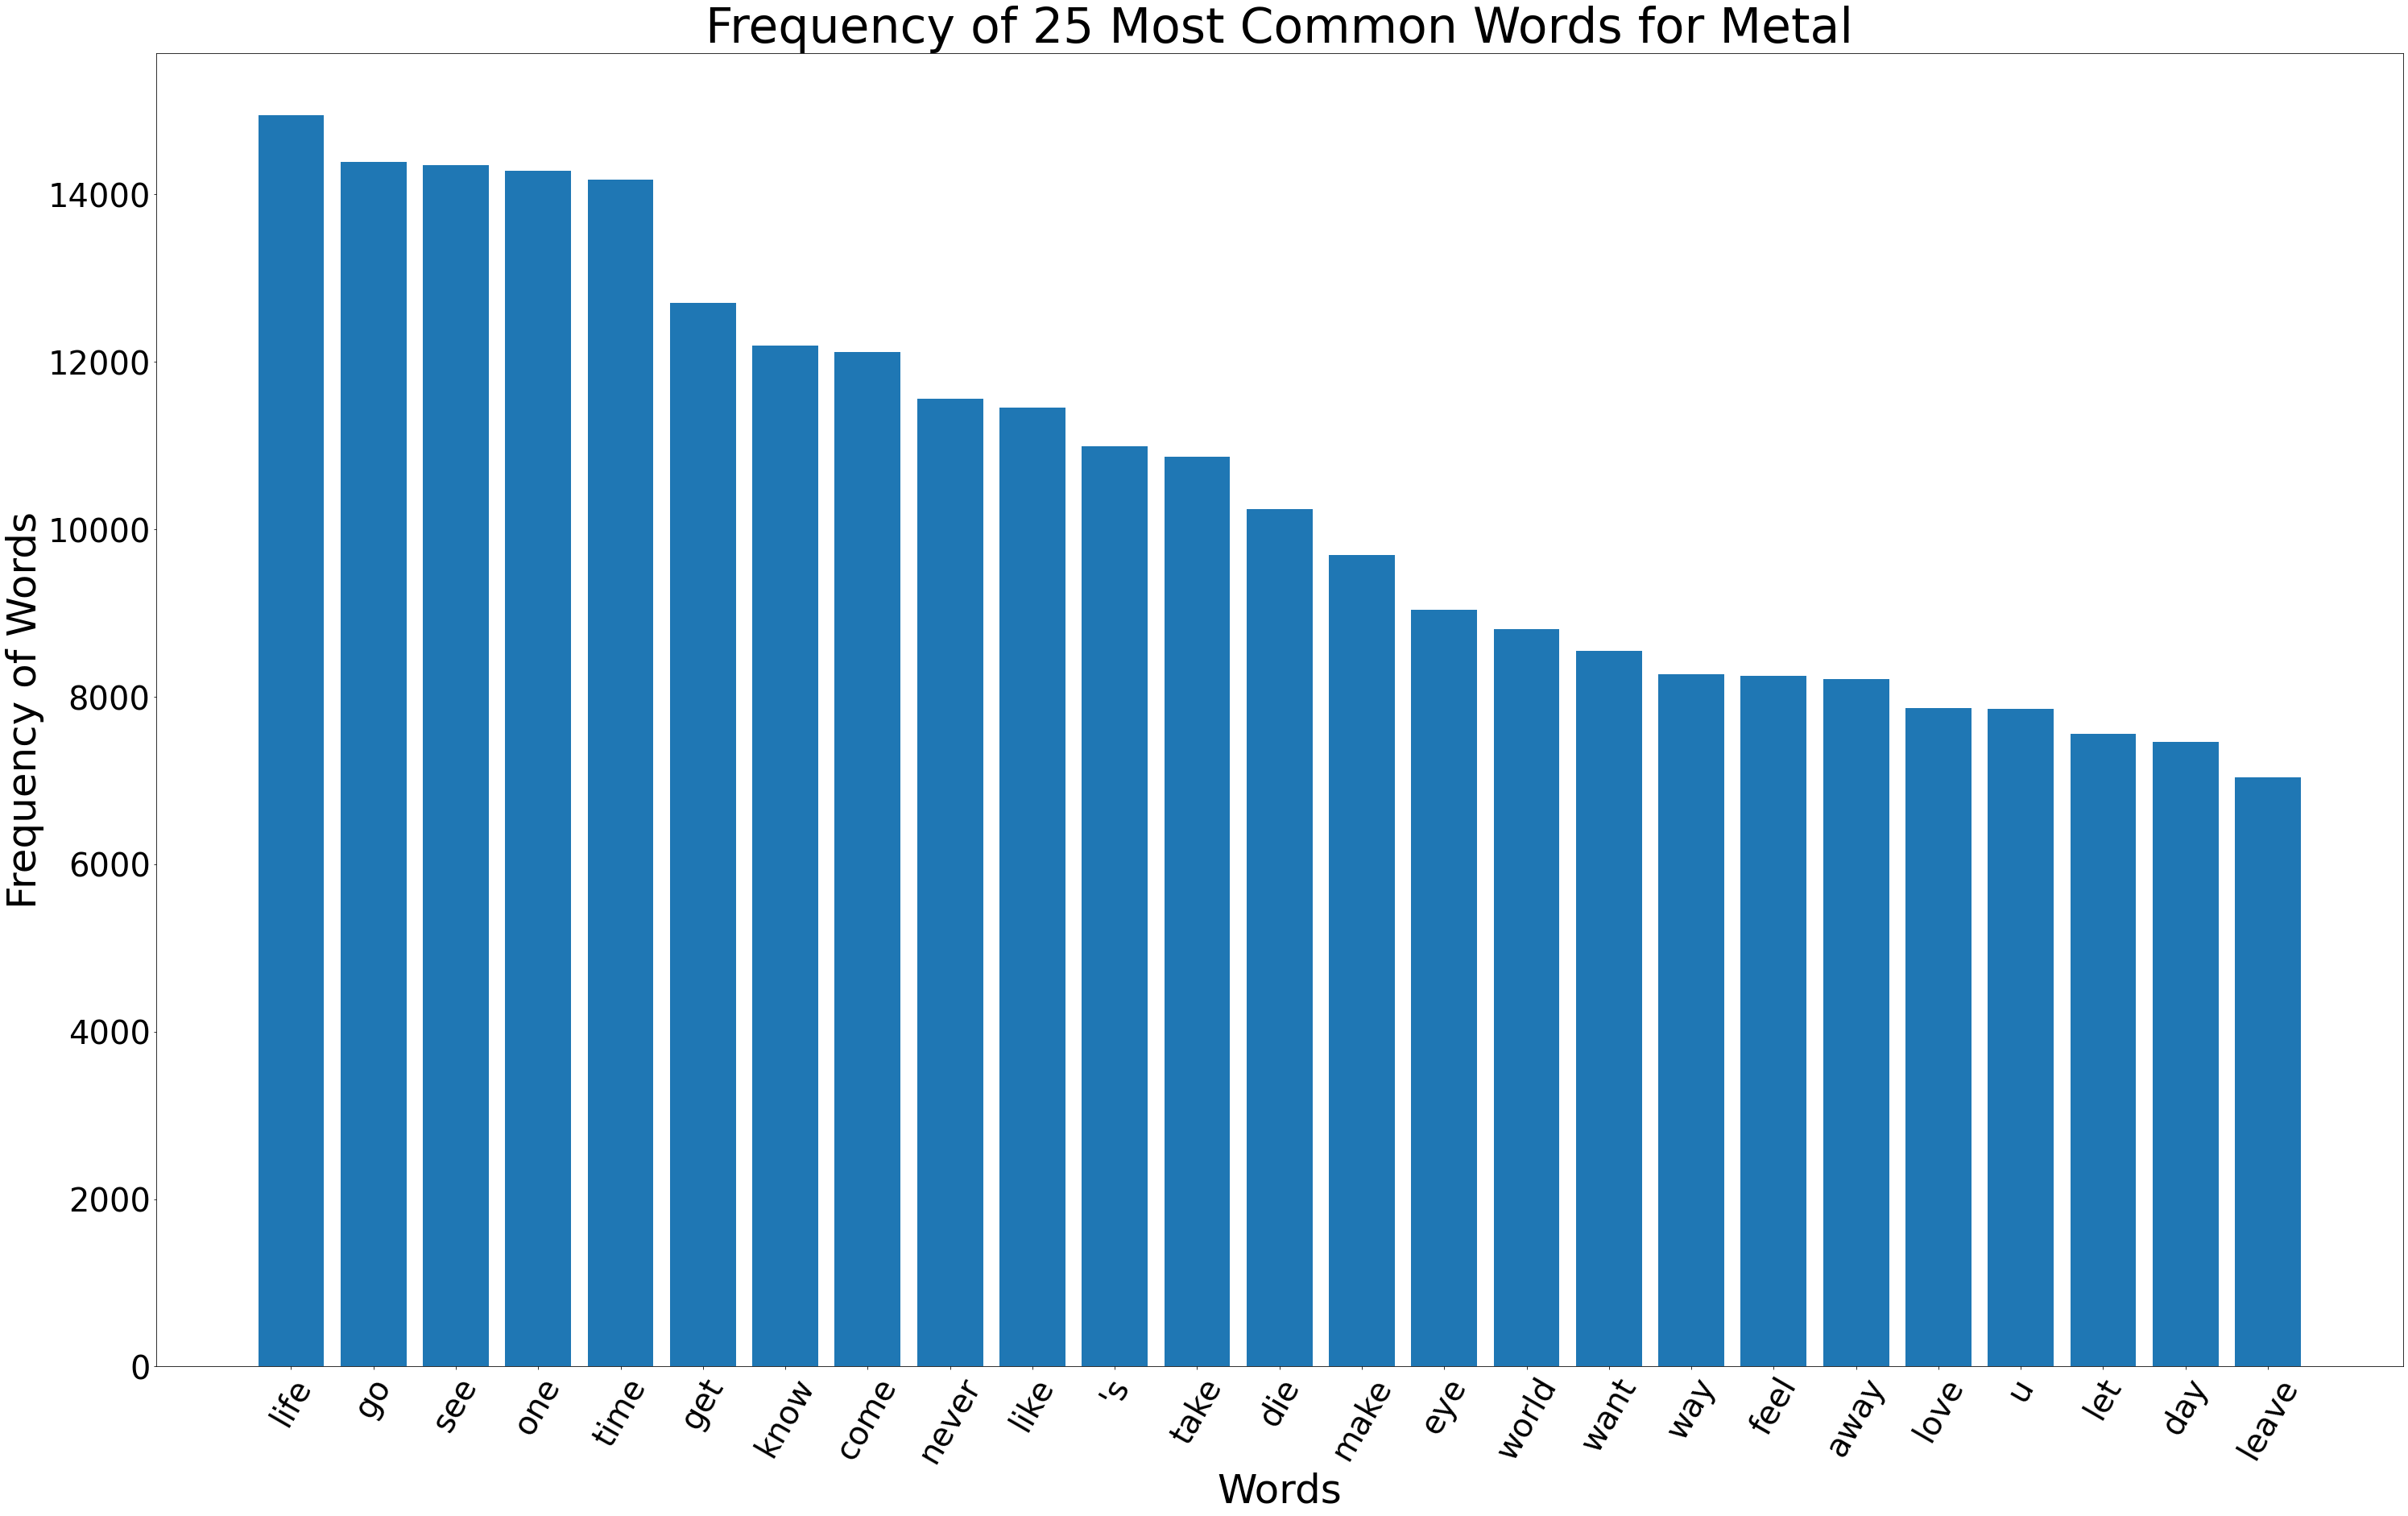

In [34]:
print_freq('Metal')

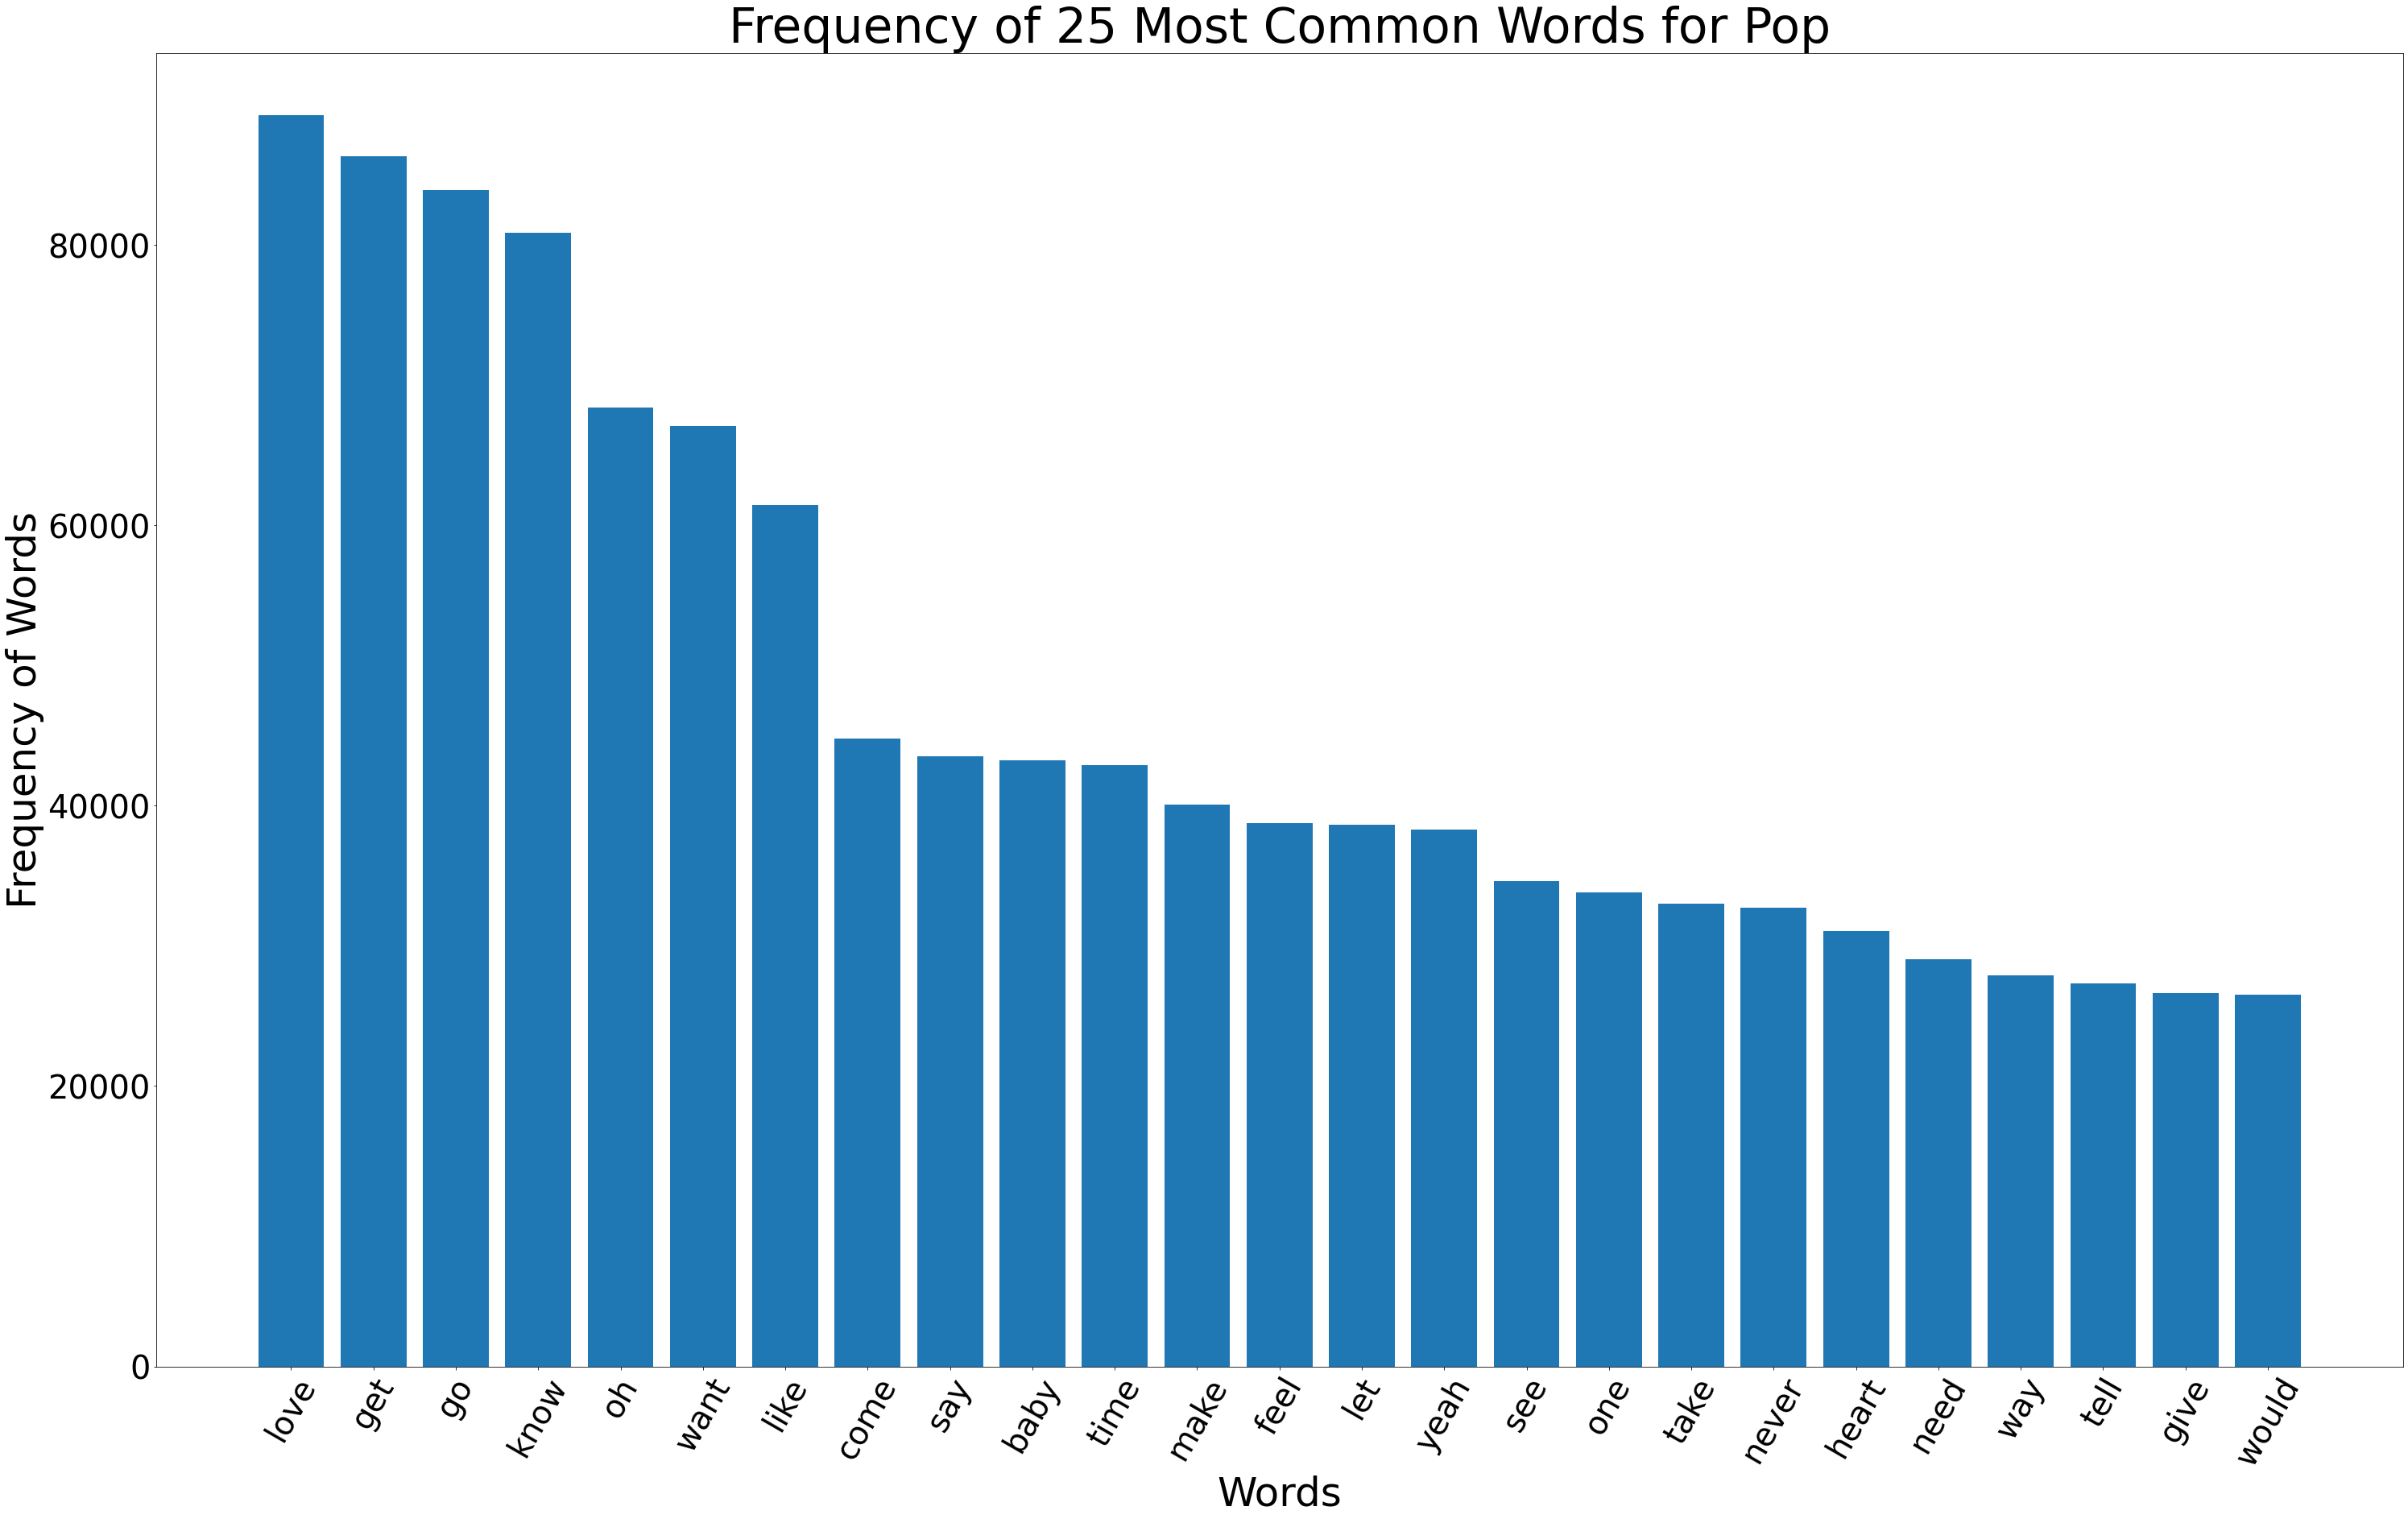

In [35]:
print_freq('Pop')

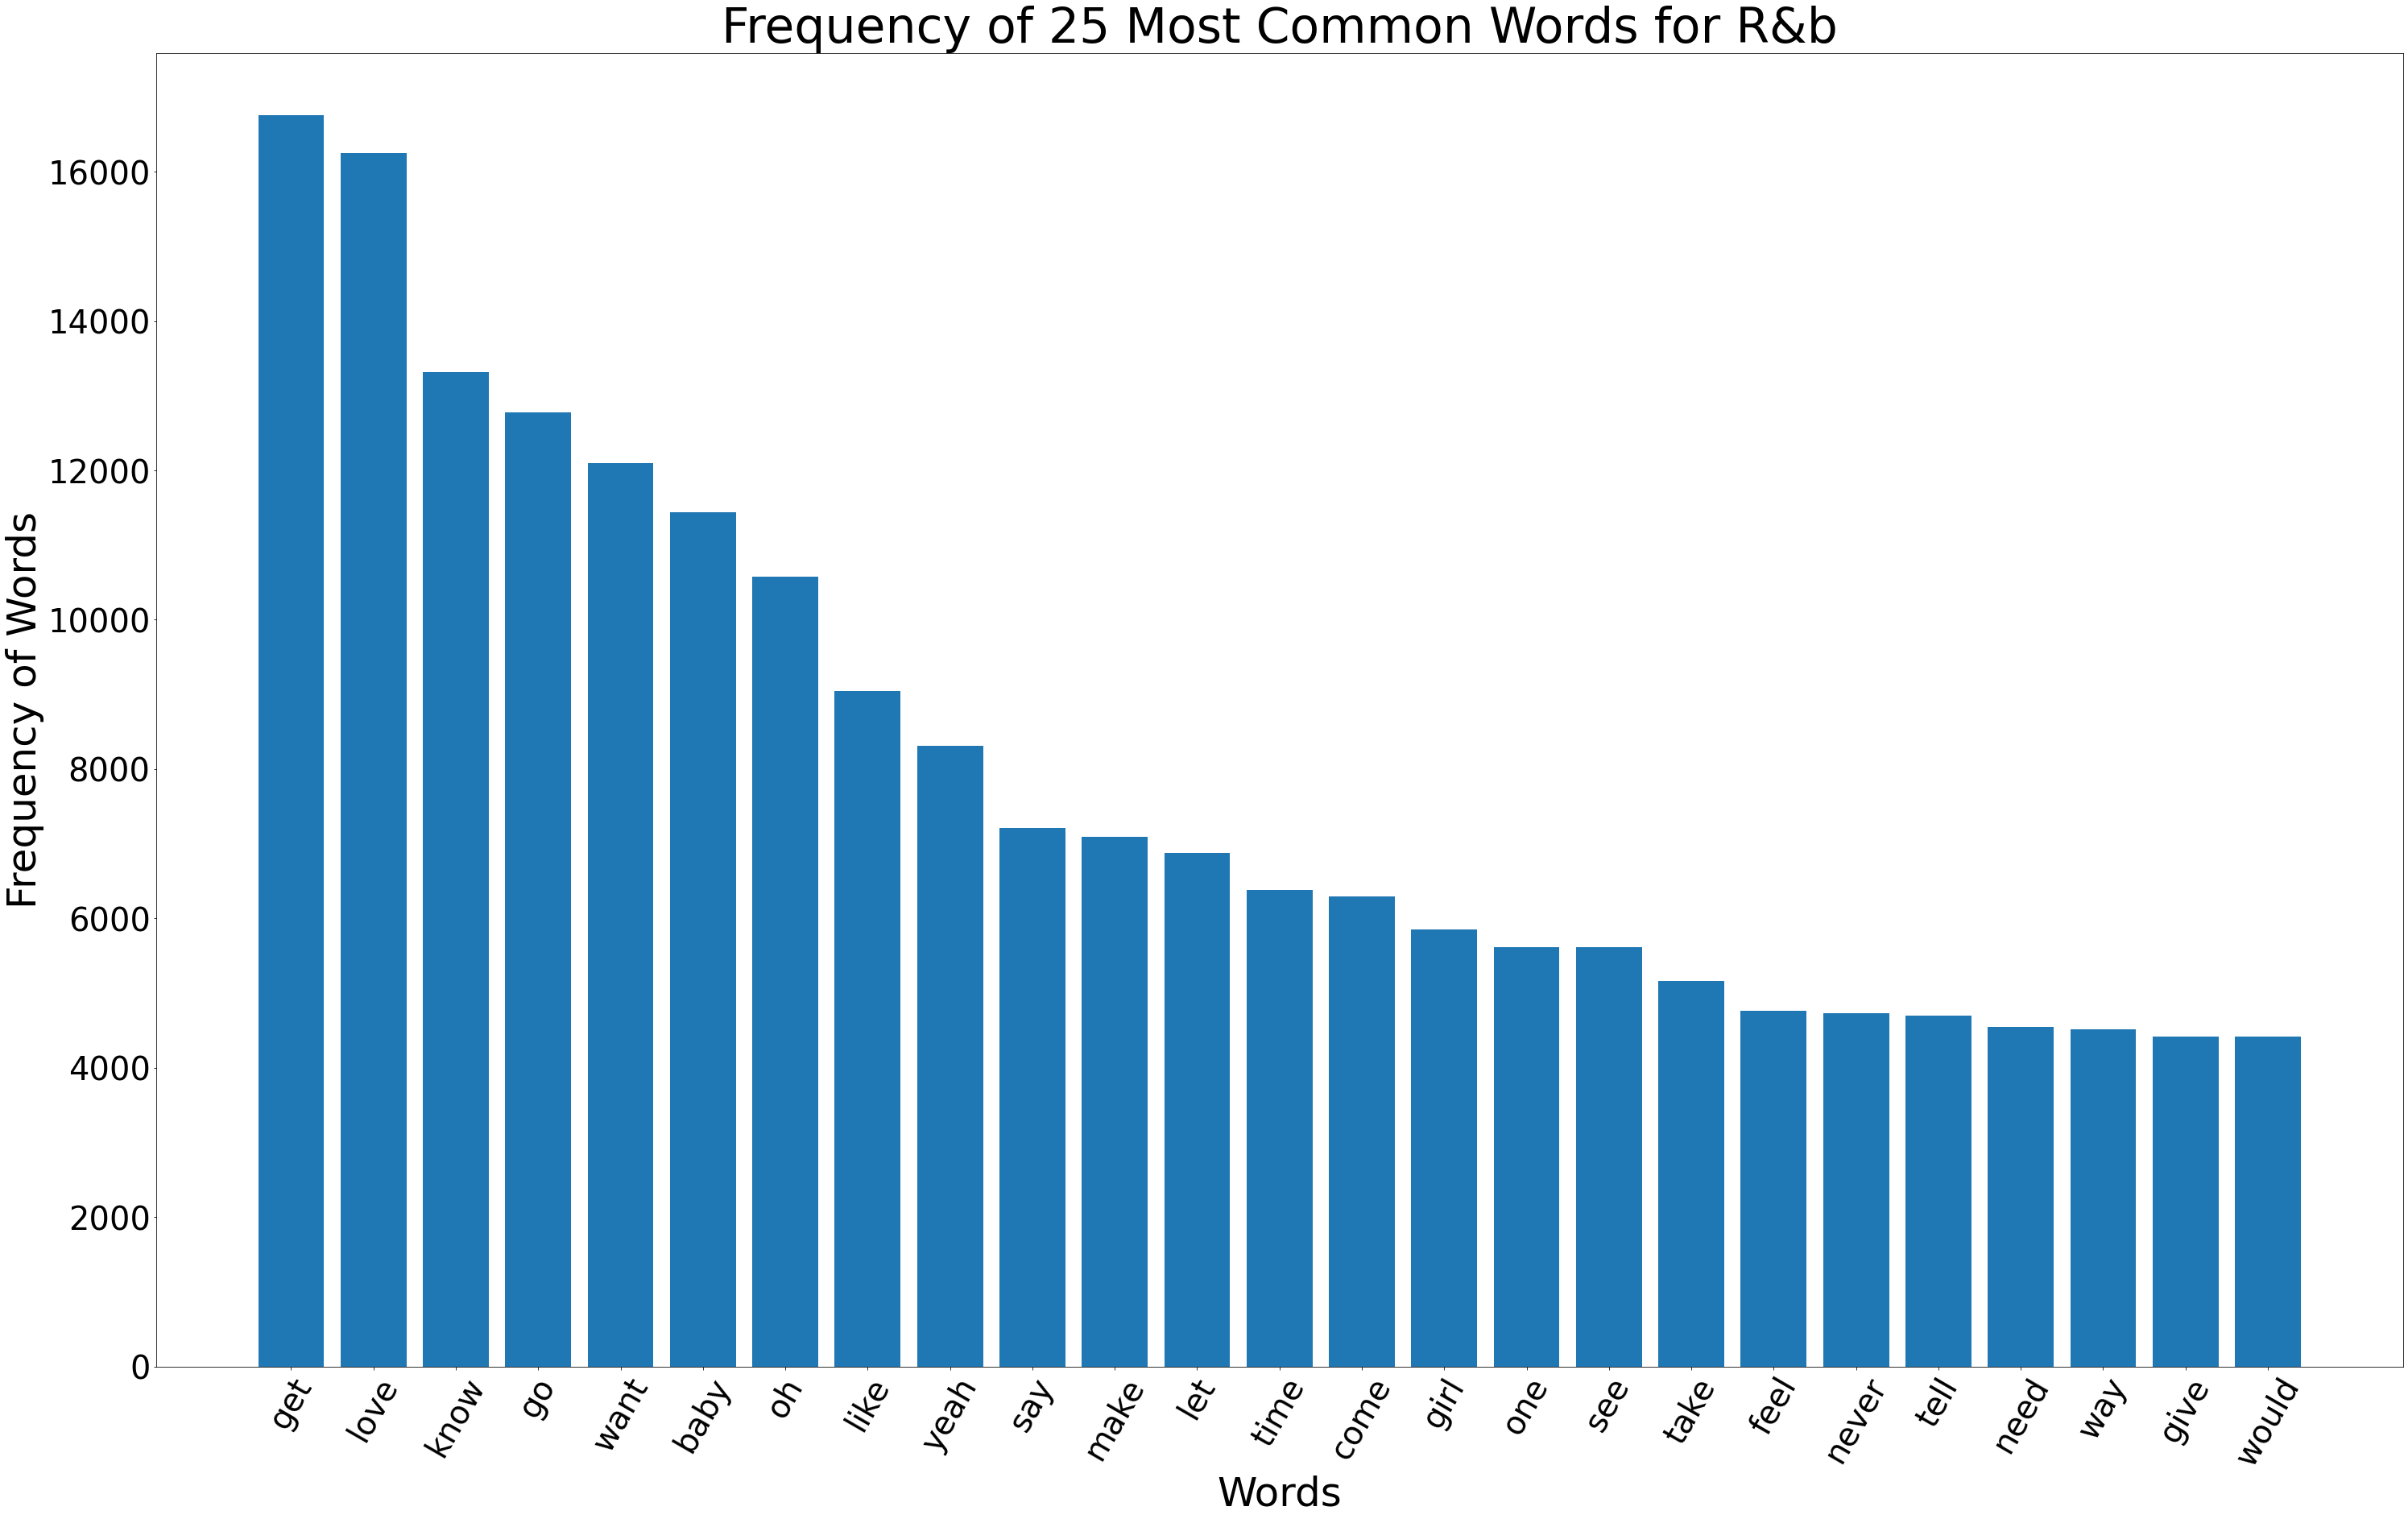

In [36]:
print_freq('R&b')

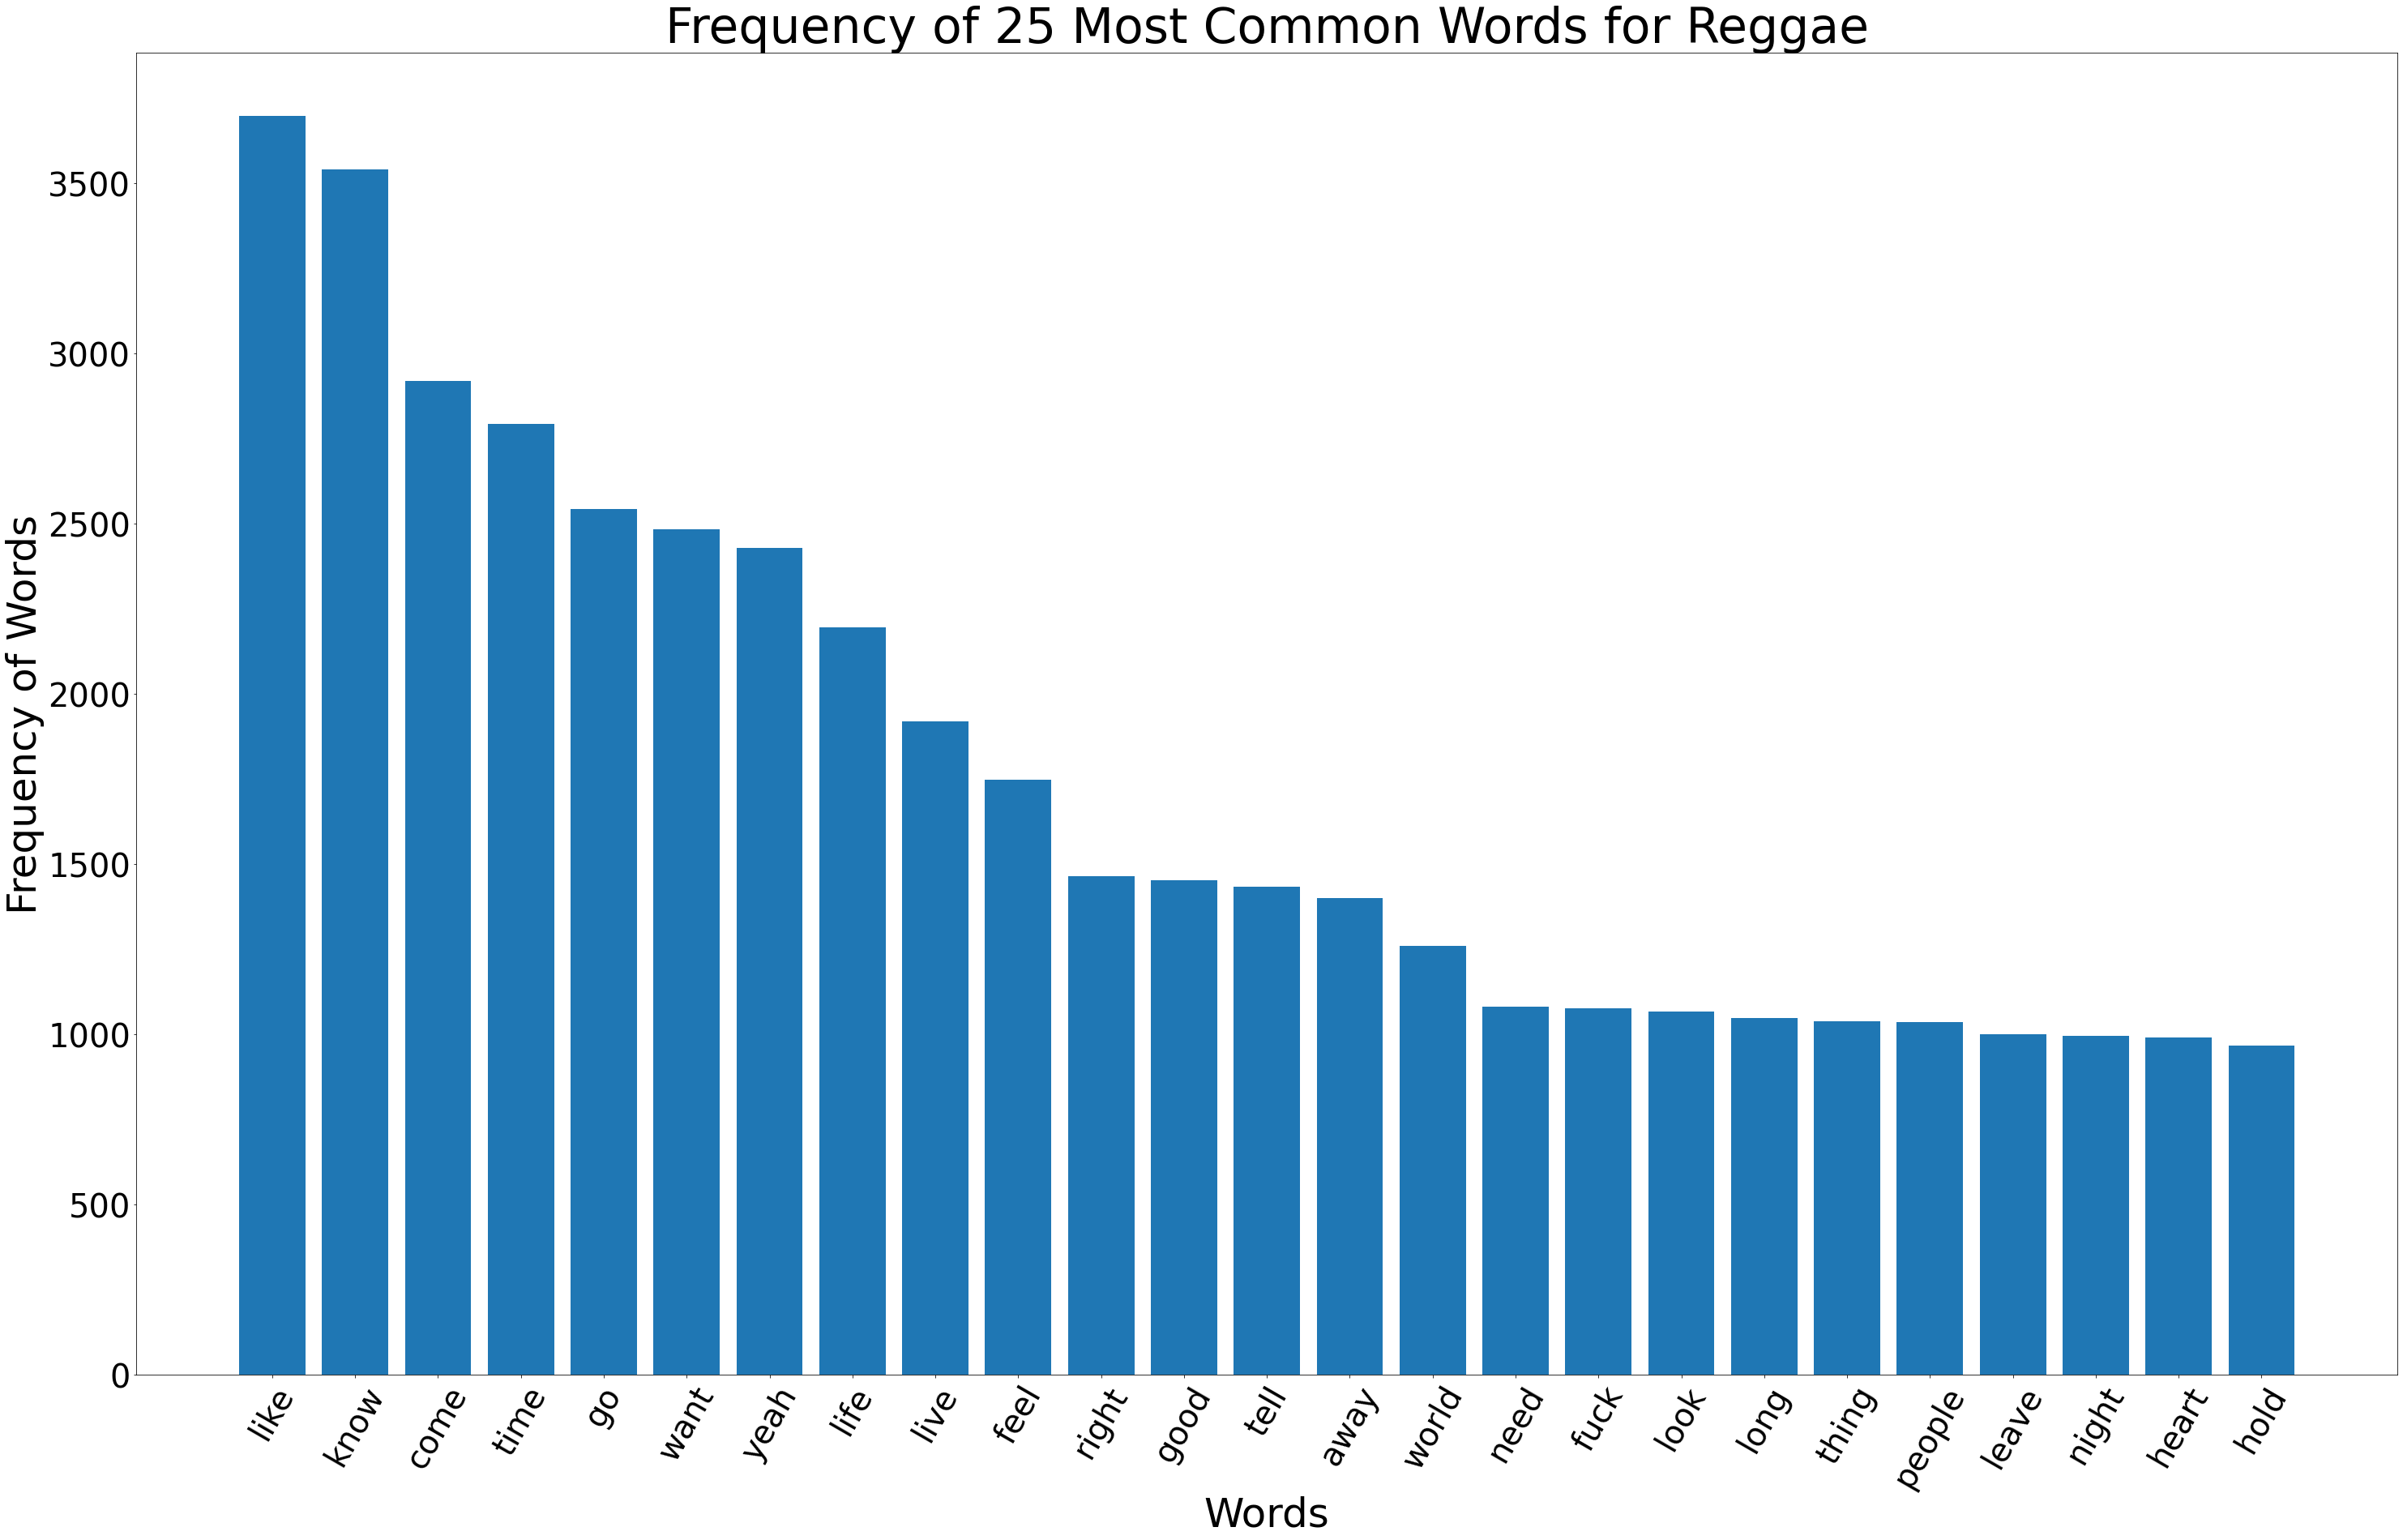

In [37]:
print_freq('Reggae')

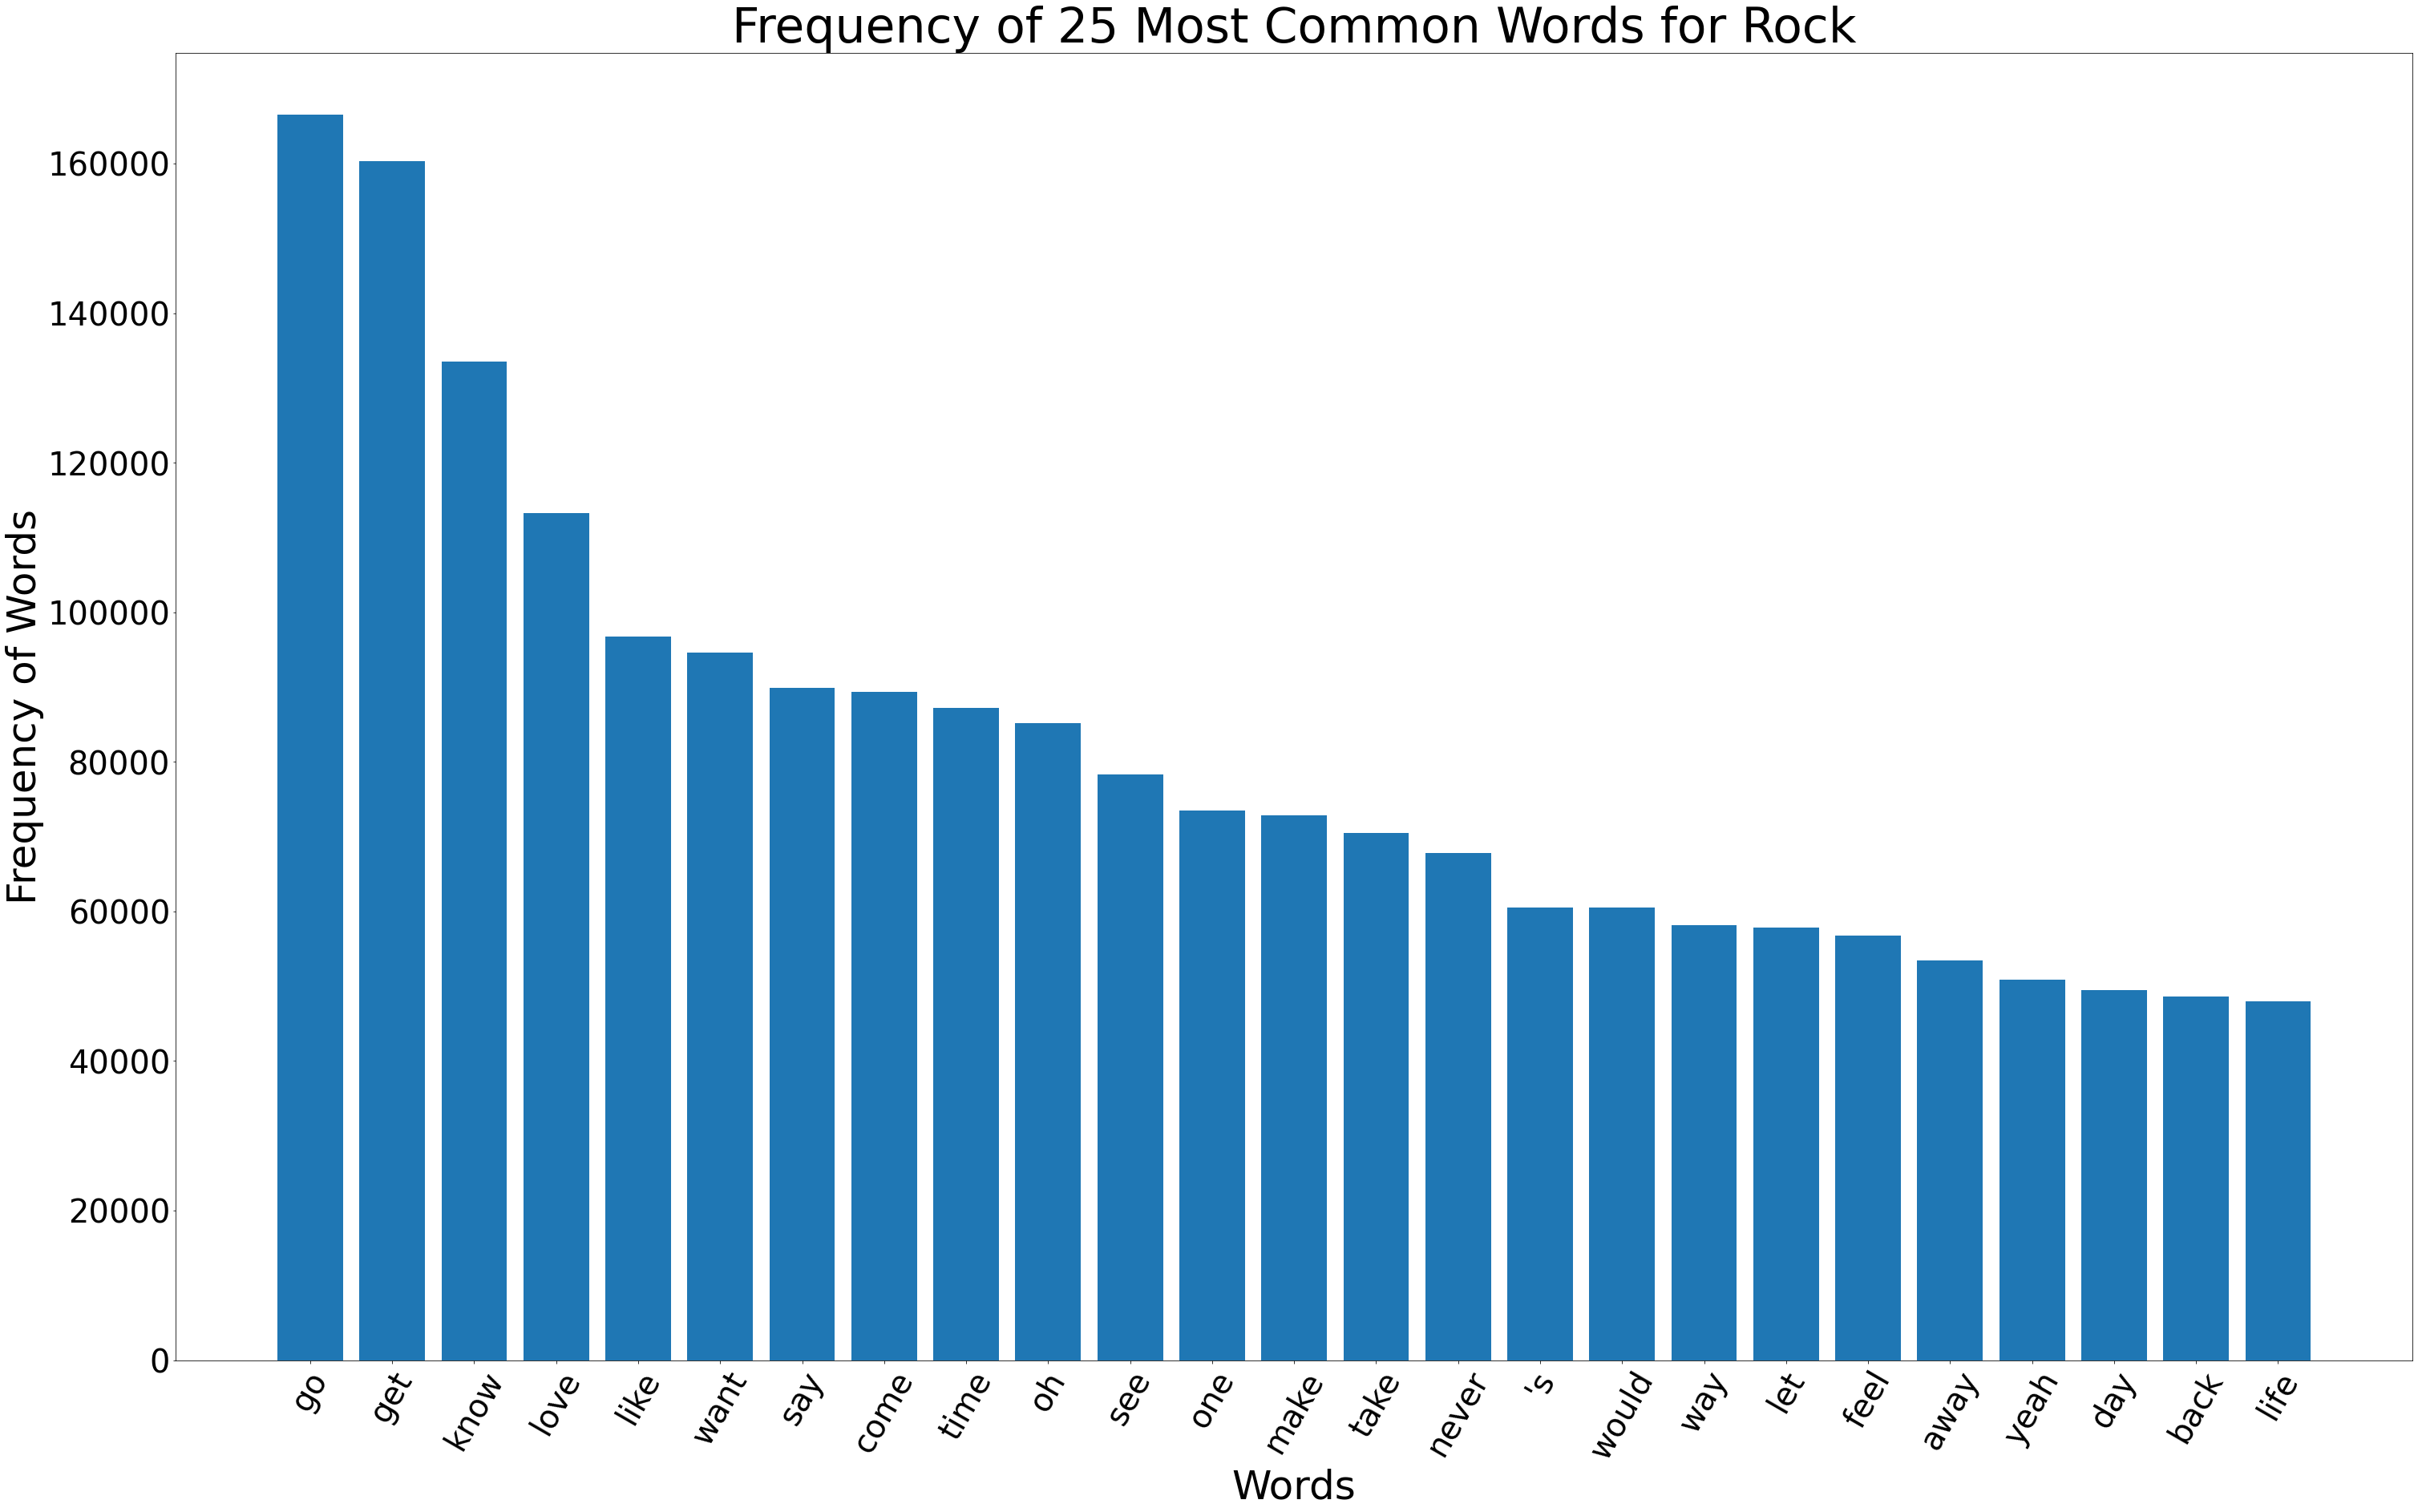

In [38]:
print_freq('Rock')

In [ ]:
# Topic Modeling using 1) LDA (Latent Dirichlet Allocation) and 2) NMF (Non-Negative Matrix Factorization)